In [2]:
# load data and processing


In [3]:
import numpy as np
import scipy as sp
from scipy.linalg import norm
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy.matlib
import pandas as pd

from allensdk.api.queries.ontologies_api import OntologiesApi
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
from mcmodels.core import VoxelModelCache

import pickle

import networkx as nx
import plotly.offline as py
import plotly.graph_objects as go
import re

import sklearn as sk
# import plotly.express as px

/Users/Allen/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.linear_model.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/Allen/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [4]:
import plotly.express as px
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none'

In [5]:
# load helper functions
from helper import load_hierarchy, plot_connectivity, generate_connectivity, generate_random_connectivity
from helper import load_celldensity, load_interneurondensity, interneuronDensityProcessing
import modelHelper

In [7]:
filepath = './'  # change path accordingly
libfilepath = './lib/'  # change path accordingly

# load the harris hierarchy N =37; 
area_list_hier = ['ACAd', 'ACAv', 'AId', 'AIp', 'AIv', 'AUDd', 'AUDp', 'AUDpo', 'FRP', 'ILA', 'MOp', 'MOs', 'ORBl',
         'ORBm', 'ORBvl', 'PL', 'RSPagl', 'RSPd', 'RSPv', 'SSp-bfd', 'SSp-ll', 'SSp-m', 'SSp-n',
         'SSp-tr', 'SSp-ul', 'SSs', 'TEa', 'VISa', 'VISal', 'VISam', 'VISl', 'VISli', 'VISp',
         'VISpl', 'VISpm', 'VISpor', 'VISrl']  # list of areas in the current model based on published paper.
        # SSp-un and VISC are removed. 

hierfilename = 'mouse_harrishier_extracted_CC_published.csv'

[harrisHierarchy, harrisHierarchy_df] = load_hierarchy(libfilepath, hierfilename, area_list_hier)
harrisHierarchy_df.to_csv('results/dfHarrisHier.csv')

In [8]:
harrisHierarchy_df

,hierarchy index
ACAd,0.940515
ACAv,0.893323
AId,0.598768
AIp,0.301334
AIv,1.000000
AUDd,0.247638
AUDp,0.166607
AUDpo,0.755853
FRP,0.753635
ILA,0.596419


In [9]:
area_list = ['ACAd', 'ACAv', 'AId', 'AIp', 'AIv', 'AUDd', 'AUDp', 'AUDpo', 'AUDv', 'ECT', 'FRP', 'GU', 'ILA', 'MOp', 'MOs', 'ORBl',
         'ORBm', 'ORBvl', 'PERI', 'PL', 'RSPagl', 'RSPd', 'RSPv', 'SSp-bfd', 'SSp-ll', 'SSp-m', 'SSp-n',
         'SSp-tr', 'SSp-ul', 'SSp-un', 'SSs', 'TEa','VISC', 'VISa', 'VISal', 'VISam', 'VISl', 'VISli', 'VISp',
         'VISpl', 'VISpm', 'VISpor', 'VISrl']
n_areas = len(area_list)

In [10]:
# define divisions from Harris et al.
div = {'somatomotor':['SSp-bfd','SSp-tr','SSp-ll','SSp-ul',
                     'SSp-un','SSp-n','SSp-m','SSs','MOp','MOs'],
      'visual':['VISal','VISl','VISp','VISpl',
                'VISli','VISpor','VISrl'],
      'medial':['VISa','VISam','VISpm','RSPagl',
               'RSPd','RSPv'],
      'prefrontal':['FRP','ACAd','ACAv','PL',
                   'ILA','ORBl','ORBm','ORBvl'],
      'lateral':['AId','AIv','AIp','VISC',
                 'GU','TEa','PERI','ECT'],
      'auditory':['AUDd','AUDp','AUDpo','AUDv']}

div_color_list = np.array([[255, 140, 0],
                           [169, 164, 217],
                           [22, 37, 128],
                           [220,20,60],
                           [218,165,32],
                           [91,  0,  105]])/255
# div_color_list = {
#     'somatomotor':[255, 140, 0],
#       'visual':[169, 164, 217],
#       'medial':[22, 37, 128],
#       'prefrontal':[220,20,60],
#       'lateral':[218,165,32],
#       'auditory':[91,  0,  105]}

div_name_list = ['somatomotor',
                 'visual',
                 'medial',
                 'prefrontal',
                 'lateral',
                 'auditory']

In [11]:
def plotHiernotebook(hierarchy_df, dotSize, yaxis, figureSize, fontSize, saveFig, fileName):
        # seaborn.set()
    dfRaw = hierarchy_df.sort_values(hierarchy_df.columns[0])

    fig = plt.figure(figsize = figureSize, dpi=300, facecolor='w', edgecolor='k')
    plt.rcParams.update({'font.size': fontSize})
    
    xx = np.arange(len(hierarchy_df))
    plt.plot(xx, dfRaw.values, '.-', markersize=dotSize, color='k')
    plt.xticks(xx, dfRaw.index, rotation = 90, fontsize=fontSize*0.6)
    plt.ylabel(yaxis) #r'$e_i/e_1$'
    # regPV = sk.linear_model.LinearRegression()
    # xx2 = xx[np.newaxis].T
    # regPV.fit(xx2, dfRaw.values)
    # print(regPV.coef_, regPV.intercept_)
    # plt.plot(xx, xx * regPV.coef_[0][0] + regPV.intercept_[0], alpha = 0.5)
    ax = plt.gca()
#     [t.set_color('red') for t in ax.xaxis.get_ticklabels()]
    for t in ax.xaxis.get_ticklabels():
        label = t._text
        for i in range(6):
            if label in div[div_name_list[i]]:
                t.set_color(div_color_list[i])
    # plt.grid(alpha = 0.5)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if saveFig:
        plt.savefig('figure/' + fileName, dpi=300, bbox_inches='tight',transparent=True)

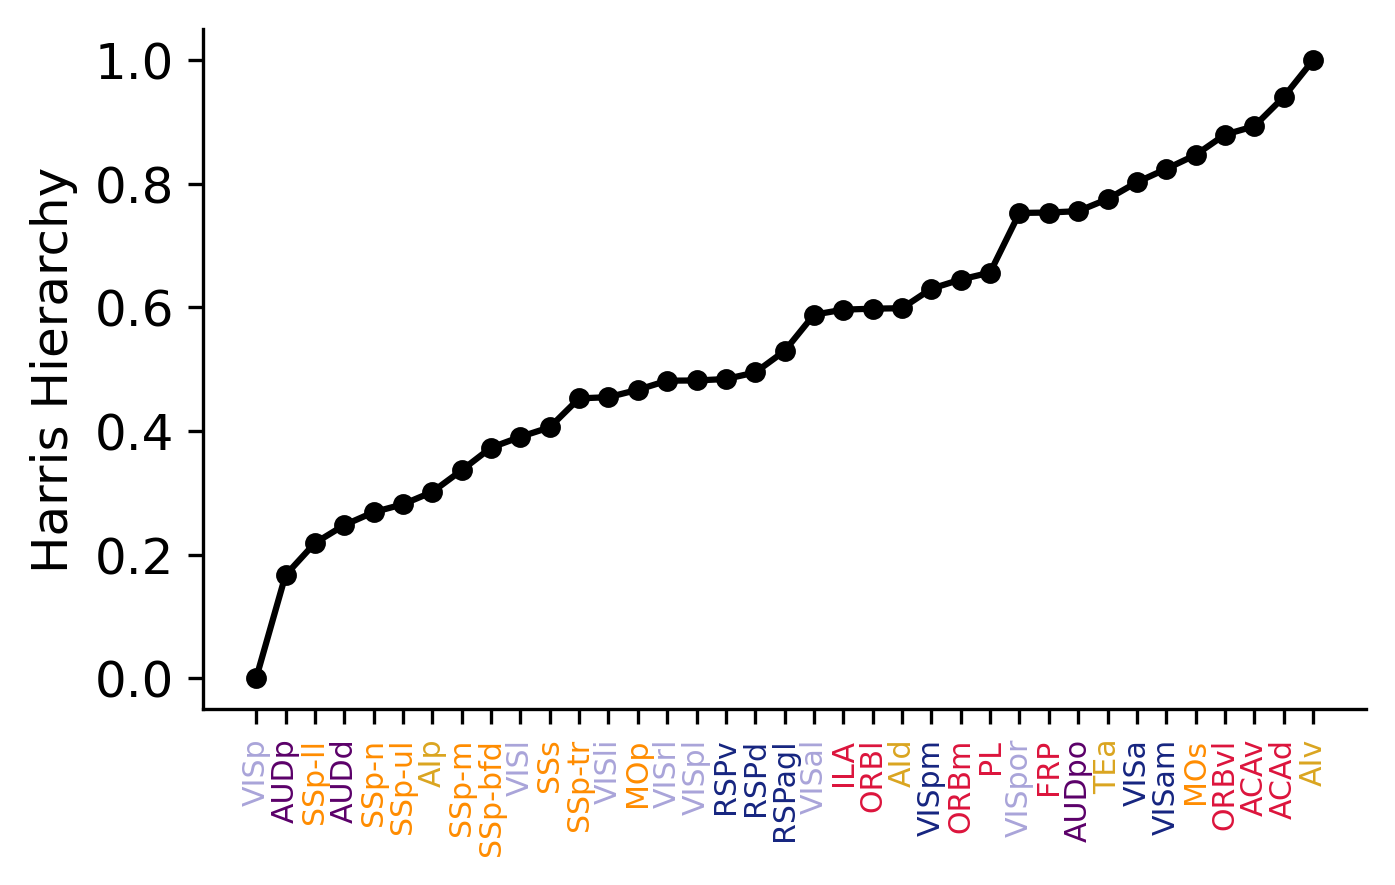

In [12]:
plotHiernotebook(harrisHierarchy_df, 8, r'Harris Hierarchy', (5,3), 12, True, 'loadDataProcessing/harrisHierarchyPlotnotebook.svg')

In [13]:
# load connectivity matrix
mcc = MouseConnectivityCache(manifest_file='connectivity/mouse_connectivity_manifest.json')
# The manifest file is a simple JSON file that keeps track of all of
# the data that has already been downloaded onto the hard drives.
# If you supply a relative path, it is assumed to be relative to your
# current working directory.

# grab the StructureTree instance
structure_tree = mcc.get_structure_tree()

oapi = OntologiesApi()

# get the ids of all the structure sets in the tree
# structure_set_ids = structure_tree.get_structure_sets()

# download and cache the latest voxel model
# this method returns a tuple with object types:
# (VoxelConnectivityArray, Mask, Mask)
cache = VoxelModelCache(manifest_file='connectivity/voxel_model_manifest.json')

# extracting the cortical subnetwork. get the normalized connectvity density for ipsi side.
normalized_connection_density = cache.get_normalized_connection_density()
full_matrix = normalized_connection_density['ipsi']  # .loc[cortex_ids_int][cortex_ids_str]
mat = np.array(full_matrix)

# cortex
cortex_structures = structure_tree.get_structures_by_set_id([688152357]) # first get the full info of cortex area
# cortex_structures_refined = []
# for s in cortex_structures:
#     if s['id'] in full_matrix.index:
#         cortex_structures_refined.append(s)
cortex_ids_int = [s['id'] for s in cortex_structures]  # get the cortex area id
cortex_ids_str = [str(s['id']) for s in cortex_structures]  
cortex_acr = [s['acronym'] for s in cortex_structures]
cortex_names = [s['name'] for s in cortex_structures]

#thalamus
thal_structures = structure_tree.get_structures_by_set_id([688152363])
thal_structures_refined = [] # some of the thalmic structure not in the cconnectivity matirx
for s in thal_structures:
    if s['id'] in full_matrix.index:
        thal_structures_refined.append(s)

thal_ids_int = [s['id'] for s in thal_structures_refined] # store as a int
thal_ids_str = [str(s['id']) for s in thal_structures_refined] # store as a str
thal_acr = [s['acronym'] for s in thal_structures_refined]
thal_names = [s['name'] for s in thal_structures_refined]


cortical_area_number = np.size(cortex_acr)
print(cortical_area_number)

# W = mat[0:cortical_area_number, 0:cortical_area_number]  # extract the cortical areas

W_ = full_matrix.loc[cortex_ids_int][cortex_ids_str] # this gives the cortico cortical connection
W_cxth_ = full_matrix.loc[cortex_ids_int][thal_ids_str] # this gives cx to thal connecitions shape (43, 40)
W_thcx_ = full_matrix.loc[thal_ids_int][cortex_ids_str] # this gives thal to cx connecitions shape (40, 43)
W = np.array(W_).transpose() # ake a transpose of the W since what the paper used in the transponsed version.
W_cxth = np.array(W_cxth_).transpose()
W_thcx = np.array(W_thcx_).transpose()

2024-01-01 21:33:39,303 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://download.alleninstitute.org/publications/A_high_resolution_data-driven_model_of_the_mouse_connectome/normalized_connection_density.csv.gz


43


RT
(39, 43)
(43, 39)
39


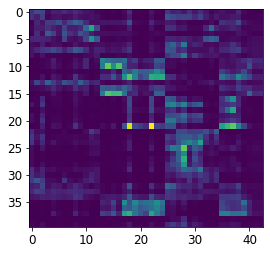

In [14]:
# not include RT
print(thal_acr[34])
thal_acr.remove('RT')
plt.imshow(W_cxth)
W_cxth = np.delete(W_cxth, 34, 0)
print(W_cxth.shape)
W_thcx = np.delete(W_thcx, 34, 1)
print(W_thcx.shape)

# save thalamic arealist
print(len(thal_acr))
np.savetxt("results/thal_list.csv", thal_acr, delimiter=",", fmt = '%s')


array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

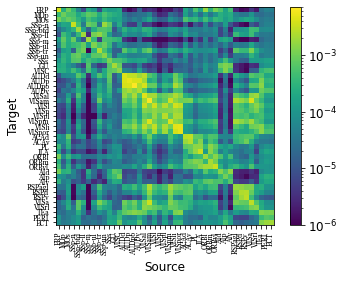

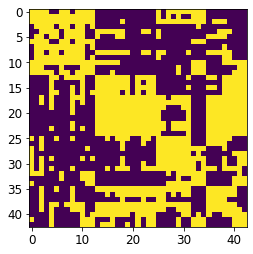

In [15]:
# peek on the connectivity
plot_connectivity(W, cortex_acr,savefig=True)
plt.figure()
plt.imshow(W>1e-4)
W>0 / (len(W)**2 - len(W))

In [16]:
    # areaidxlist = np.arange(len(cortex_acr))
    # # extract the connectivity for list of areas.
    # W_ = W[areaidxlist, :][:, areaidxlist]

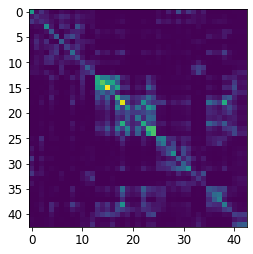

In [17]:
plt.imshow(W)


In [18]:
# generate connectivity matrix 
# this function also sorted the cortical areas in W_cxth and W_thcx.
conn_cxcx,conn_cxth, conn_thcx, area_list_sort, thal_list_sort = generate_connectivity(
    W, cortex_acr, W_cxth, W_thcx, thal_acr ,imgout=False)

(43, 43)
['ACAd', 'ACAv', 'AId', 'AIp', 'AIv', 'AUDd', 'AUDp', 'AUDpo', 'AUDv', 'ECT', 'FRP', 'GU', 'ILA', 'MOp', 'MOs', 'ORBl', 'ORBm', 'ORBvl', 'PERI', 'PL', 'RSPagl', 'RSPd', 'RSPv', 'SSp-bfd', 'SSp-ll', 'SSp-m', 'SSp-n', 'SSp-tr', 'SSp-ul', 'SSp-un', 'SSs', 'TEa', 'VISC', 'VISa', 'VISal', 'VISam', 'VISl', 'VISli', 'VISp', 'VISpl', 'VISpm', 'VISpor', 'VISrl']
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42]
[25 26 32 33 34 13 14 15 16 42  0 11 28  1  2 29 30 31 41 27 35 36 37  4
  5  6  3  8  7  9 10 40 12 38 17 18 19 23 20 21 22 24 39]
(39, 43)


In [19]:
print(area_list)

['ACAd', 'ACAv', 'AId', 'AIp', 'AIv', 'AUDd', 'AUDp', 'AUDpo', 'AUDv', 'ECT', 'FRP', 'GU', 'ILA', 'MOp', 'MOs', 'ORBl', 'ORBm', 'ORBvl', 'PERI', 'PL', 'RSPagl', 'RSPd', 'RSPv', 'SSp-bfd', 'SSp-ll', 'SSp-m', 'SSp-n', 'SSp-tr', 'SSp-ul', 'SSp-un', 'SSs', 'TEa', 'VISC', 'VISa', 'VISal', 'VISam', 'VISl', 'VISli', 'VISp', 'VISpl', 'VISpm', 'VISpor', 'VISrl']


In [20]:
# # quick check which thalamic area project to cortical area  # SSp-n 26  MOs 14 
# np.set_printoptions(precision=3, suppress=True)
# print(conn_thcx[14, :]*1e5) 

In [22]:
# load the volume data and make processing.
dataFile = 'CCFv3SuppTable2.csv'
df = pd.read_csv(dataFile, header=1)
df.head()

,order,structure ID,full structure name,abbreviation,parent_id,depth in tree,structure_id_path,total_voxel_counts (10 um),Structure independently delineated (not merged to form parents),Major Division,"""Summary Structure"" Level for Analyses"
0,0,997,root,root,NaN,0,/997/,506032520,NaN,NaN,NaN
1,1,8,Basic cell groups and regions,grey,997.0,1,/997/8/,449594328,NaN,NaN,NaN
2,2,567,Cerebrum,CH,8.0,2,/997/8/567/,275860156,NaN,NaN,NaN
3,3,688,Cerebral cortex,CTX,567.0,3,/997/8/567/688/,221533548,NaN,NaN,NaN
4,4,695,Cortical plate,CTXpl,688.0,4,/997/8/567/688/695/,212625646,NaN,NaN,NaN


In [23]:
volumeList = []
for area in area_list:
    volume = float(df[df['abbreviation'] == area]['total_voxel_counts (10 um)'])
    volumeList.append(volume)
volume_df = pd.DataFrame([x for x in zip(area_list, volumeList)], columns=['area', 'volume'])
print(volume_df['volume'].max()/volume_df['volume'].min())
volume_df.head()



26.61938766800925


,area,volume
0,ACAd,3131334.0
1,ACAv,2408528.0
2,AId,3724650.0
3,AIp,2434626.0
4,AIv,1734830.0


In [24]:
fig = px.line(volume_df, 'area', 'volume')
fig.show()
fig.write_image("figure/loadDataProcessing/areaVolume.svg", width=1000, height=350, scale=1)

In [25]:
# load layer 23 cell density
# rawl23density_df = pd.read_csv('results/l23cell_density_iso.csv')
# rawl23density_df.head()

In [26]:
# # generate connectivity that is normalized by volume   and using layer 23 cell density
# areaV3toV2 = {'VISa':'PTLp', 'FRP':'PL', 'VISli':'VISl', 
#         'VISrl':'PTLp', 'VISpor':'VISpl', 'SSp-un': 'SSp-ul'}  # copied from helper.py 
# l23densityList = []
# for area in area_list: 
# #     if curRow.empty: 
#     if area in areaV3toV2: 
#         curRow = rawl23density_df.loc[rawl23density_df['Acronym'] == areaV3toV2[area]] 
#     else:
#         curRow = rawl23density_df.loc[rawl23density_df['Acronym'] == area] 
#     l23densityList.append(float(curRow['Neurons [mm-3]'])) 
# l23density_df = pd.DataFrame([x for x in zip(area_list, l23densityList)], 
#                           columns=['area', 'l23 neuron density'])

# l23density_df.head()

In [30]:
# load cell density  paper: A cell atlas for the mouse brain.
rawdensityMarkram_df = pd.read_csv('results/cell_density_iso_Markram.csv')
rawdensityMarkram_df.head()

,Acronym,Regions,Cells,Neurons,Glia,Excitatory,Inhibitory,Modulatory,Astrocytes,Oligodendrocytes,Microglia
0,FRP,Frontal pole cerebral cortex,75406.15716,46677.91887,28728.23829,9082.52491,37317.769540,277.624418,736.966638,9903.620159,18087.65150
1,MOp,Primary motor area,139973.71160,65189.47578,74784.23582,56924.50748,7669.354996,595.613303,12345.803170,37286.693350,25151.73929
2,MOs,Secondary motor area,143569.82120,65792.20051,77777.62066,53895.13720,11202.789190,694.274116,8852.555741,31674.562060,37250.50286
3,SSp-n,Primary somatosensory area nose,140706.63310,66579.20852,74127.42455,59187.30815,7056.737042,335.163324,7223.614580,31560.274170,35343.53581
4,SSp-bfd,Primary somatosensory area barrel field,172443.05530,81340.09657,91102.95869,74812.41051,6139.549730,388.136331,8885.893712,38191.439360,44025.62562


In [31]:
#generate connectivity that is normalized by volume and norm by cell density
areaV3toV2 = {'VISa':'PTLp', 'FRP':'PL', 'VISli':'VISl', 
        'VISrl':'PTLp', 'VISpor':'VISpl', 'SSp-un': 'SSp-ul'}  # copied from helper.py 
densityMarkramList = []
exdensityMarkramList = []
inhdensityMarkramList = []
for area in area_list: 
#     if curRow.empty: 
    if area in areaV3toV2: 
        curRow = rawdensityMarkram_df.loc[rawdensityMarkram_df['Acronym'] == areaV3toV2[area]] 
    else:
        curRow = rawdensityMarkram_df.loc[rawdensityMarkram_df['Acronym'] == area] 
    densityMarkramList.append(float(curRow['Neurons'])) 
    exdensityMarkramList.append(float(curRow['Excitatory']))
    inhdensityMarkramList.append(float(curRow['Inhibitory']))
densityMarkram_df = pd.DataFrame([x for x in zip(area_list, densityMarkramList, exdensityMarkramList, inhdensityMarkramList)], 
                          columns=['area', 'neuron density', 'excitatory neuron density', 'inhibitory neuron density']) 

densityMarkram_df.head() 

,area,neuron density,excitatory neuron density,inhibitory neuron density
0,ACAd,66059.01898,54585.48501,10733.760190
1,ACAv,87184.88412,67950.71795,18533.718960
2,AId,70218.45077,61439.60622,8324.766385
3,AIp,76680.34983,63774.14520,12536.830050
4,AIv,69508.04572,61498.17703,7554.593054


In [32]:
fig = px.line(densityMarkram_df, 'area', 'neuron density')
fig.show()
fig.write_image("figure/loadDataProcessing/neuronDensity.svg", width=1000, height=350, scale=1)

densityMarkram_df['ratio'] = densityMarkram_df['excitatory neuron density'] / densityMarkram_df['inhibitory neuron density']
fig = px.line(densityMarkram_df, 'area', ['ratio'])
fig.show()

In [34]:
# seems not used. 
# load cell density
newrawdensity_df = pd.read_csv('results/newrawcell_density_iso.csv')
newrawdensity_df.head()

,Brain region,PV [mm^-3],std PV [mm^-3],SST [mm^-3],std SST [mm^-3],VIP [mm^-3],std VIP [mm^-3],Rest inh. [mm^-3],std Rest inh. [mm^-3],GAD67 [mm^-3],std GAD67 [mm^-3],Non inh. [mm^-3],std Non inh. [mm^-3],Neuron [mm^-3],Volumes [mm^3]
0,Basic cell groups and regions,5973.539694,0.000000,5358.546970,0.000000,1049.199722,0.000000,21529.976910,0.000000,33911.26329,0.000000,21529.976910,0.000000,167290.12520,428.955391
1,Cerebrum,2432.280489,0.000000,5223.492013,0.000000,1607.107740,0.000000,15604.680750,0.000000,24867.56099,0.000000,15604.680750,0.000000,91788.34042,267.984406
2,Cerebral cortex,2858.693804,43.558371,5029.761702,45.642886,1974.603422,31.935781,13385.134010,42.727854,23248.19293,8.644609,13385.134010,8.644609,104507.90590,216.509219
3,Cortical plate,2888.525098,0.000000,4806.314953,0.000000,2013.841285,0.000000,13105.412940,0.000000,22814.09427,0.000000,13105.412940,0.000000,106000.58200,208.074703
4,Isocortex,4167.209868,0.000000,4485.086327,0.000000,2258.434624,0.000000,7030.134426,0.000000,17940.86524,0.000000,7030.134426,0.000000,72779.54043,123.177172


In [36]:
# This is also from paper: A cell atlas for the mouse brain.   
rawdensity_df = pd.read_csv('results/cell_density_iso.csv')  # cell_density_iso.csv is same as cell_density_iso_Markram.csv
rawdensity_df.head()

areaV3toV2 = {'VISa':'PTLp', 'FRP':'PL', 'VISli':'VISl', 
        'VISrl':'PTLp', 'VISpor':'VISpl', 'SSp-un': 'SSp-ul'}  # copied from helper.py 
densityList = []

for area in area_list: 
#     if curRow.empty: 
    if area in areaV3toV2: 
#         print(rawdensity_df[rawdensity_df['Acronym'] == areaV3toV2[area]])
        curRow = rawdensity_df.loc[rawdensity_df['Acronym'] == areaV3toV2[area]]   
#         curRow = rawdensity_df.loc[]
    else:
        curRow = rawdensity_df.loc[rawdensity_df['Acronym'] == area] 
    densityList.append(float(curRow['Neurons'])) 
density_df = pd.DataFrame([x for x in zip(area_list, densityList)], 
                          columns=['area', 'neuron density']) 

density_df.head() 

,area,neuron density
0,ACAd,66059.01898
1,ACAv,87184.88412
2,AId,70218.45077
3,AIp,76680.34983
4,AIv,69508.04572


In [29]:
fig = px.line(density_df, 'area', 'neuron density')
fig.show()


In [37]:
# # plot layer 23 density
# fig = px.line(l23density_df, 'area', 'l23 neuron density')
# fig.show()

In [38]:
# modify the connectivity
# mm11
normDensity = densityList / np.mean(densityList)
densityMat = np.matlib.repmat(normDensity, len(normDensity), 1)

# normVolume = np.array(volume_df['volume'] / volume_df['volume'].mean())
normVolume = volumeList / np.mean(volumeList)
volumeMat = np.matlib.repmat(normVolume, len(normVolume), 1)

# conn_cxcx_densityNorm = conn_cxcx / (densityMat * densityMat.T)
# conn_cxcx_densityNorm = conn_cxcx / densityMat.T   # just for normalize based on target area density.
# conn_cxcx_densityNorm = conn_cxcx * volumeMat / densityMat.T   # normalize based on target area density and by volume
conn_cxcx_norm = conn_cxcx * volumeMat / densityMat.T # scaling based on volume

# conn_cxcx = conn_cxcx_norm

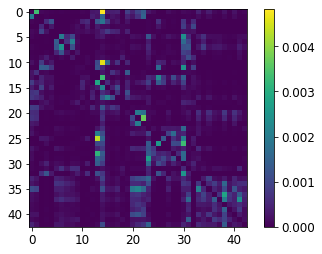

In [39]:
# sum(conn_cxcx[0, :] * hierarchy.T.squeeze()) / sum(conn_cxcx[0, :]), hierarchy[1][0]
plt.imshow(conn_cxcx_norm)
plt.colorbar()

In [40]:
# get symmetrical connectivity
sym_cxcx = 0.5 * (conn_cxcx + conn_cxcx.T)
anti_cxcx = 0.5 * (conn_cxcx - conn_cxcx.T)
sym = (norm(sym_cxcx) - norm(anti_cxcx)) / (norm(sym_cxcx) + norm(anti_cxcx))
print(sym) # if sym ==1 or -1, then conn_cxcx is symmetric. 
px.imshow(sym_cxcx, color_continuous_scale='viridis')
# conn_cxcx_norm
sym_cxcx_norm = 0.5 * (conn_cxcx_norm + conn_cxcx_norm.T)
px.imshow(sym_cxcx_norm, color_continuous_scale='viridis')

0.6739922416377906


In [41]:
noHierList = [8,9, 11,18,29,32]
print([area_list[i] for i in noHierList])
h = harrisHierarchy[:, 0]
print(h)
hierarchy = []
j = 0
for i in range(n_areas):
    if i in noHierList:
        hierarchy.append(0)
    else:
        hierarchy.append(h[j])
        j += 1
hierarchy = np.array(hierarchy)
print(hierarchy)

['AUDv', 'ECT', 'GU', 'PERI', 'SSp-un', 'VISC']
[0.94051491 0.89332282 0.5987676  0.30133441 1.         0.24763779
 0.16660726 0.75585298 0.75363472 0.59641928 0.46666142 0.84681602
 0.59798344 0.64521689 0.87977067 0.65643561 0.52951112 0.49471821
 0.48411308 0.37301437 0.21854673 0.33642137 0.26854645 0.45277745
 0.28133066 0.40594787 0.77535128 0.80261819 0.58821938 0.82426741
 0.39054902 0.45472747 0.         0.48178005 0.63032421 0.7529499
 0.48140867]
[0.94051491 0.89332282 0.5987676  0.30133441 1.         0.24763779
 0.16660726 0.75585298 0.         0.         0.75363472 0.
 0.59641928 0.46666142 0.84681602 0.59798344 0.64521689 0.87977067
 0.         0.65643561 0.52951112 0.49471821 0.48411308 0.37301437
 0.21854673 0.33642137 0.26854645 0.45277745 0.28133066 0.
 0.40594787 0.77535128 0.         0.80261819 0.58821938 0.82426741
 0.39054902 0.45472747 0.         0.48178005 0.63032421 0.7529499
 0.48140867]


In [42]:
sym_cxcx = 0.5 * (conn_cxcx + conn_cxcx.T)
anti_cxcx = 0.5 * (conn_cxcx - conn_cxcx.T)
sym = (norm(sym_cxcx) - norm(anti_cxcx)) / (norm(sym_cxcx) + norm(anti_cxcx))
print(sym) # if sym ==1 or -1, then conn_cxcx is symmetric. 
px.imshow(sym_cxcx, color_continuous_scale='viridis')
# conn_cxcx_norm
sym_cxcx_norm = 0.5 * (conn_cxcx_norm + conn_cxcx_norm.T)
px.imshow(sym_cxcx_norm, color_continuous_scale='viridis')

0.6739922416377906


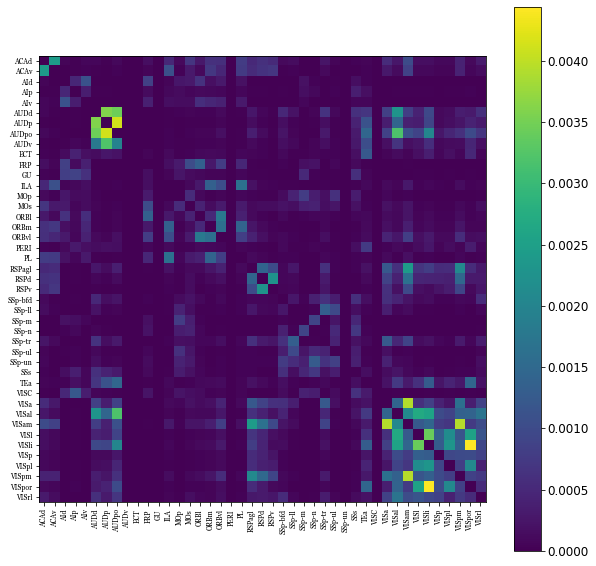

In [43]:
conn_withHier = np.zeros((n_areas, n_areas))
conn_withHier_norm = np.zeros((n_areas, n_areas))
for i in range(n_areas):
    for j in range(n_areas):
        if j in noHierList:
            continue
        conn_withHier[i, j] = sym_cxcx[i, j]
#         conn_withHier[i, j] = conn_cxcx[j, i]
        conn_withHier_norm[i, j] = sym_cxcx_norm[i, j]
#         conn_withHier_norm[i, j] = conn_cxcx_norm[j, i]

plt.figure(figsize=(10,10))
plt.imshow(conn_withHier)
plt.colorbar()
plt.xticks(list(range(n_areas)),area_list,rotation=90,fontname='Georgia',fontsize=7)
plt.yticks(list(range(n_areas)),area_list,fontname='Georgia',fontsize=7)
plt.show()
# conn_6_thres = conn_6 * (conn_6 > threshold_6)
# conn_6_norm_thres = conn_6_norm * (conn_6_norm > threshold_6_norm)


In [44]:
def getPredHi(areaNo, conn, beta):  # not used anymore
    s1, s2 = 0, 0
    for i in range(n_areas):
        if i in noHierList:
            continue
        s1 += np.exp(beta * conn[areaNo, i]) * hierarchy[i]
        s2 += np.exp(beta * conn[areaNo, i])
    s = s1 / s2
#     h = 0.67 * s + 0.15
    h = 0.73 * s + 0.11
    return h

def getPredHi2(areaNo, conn): 
    s1, s2 = 0, 0
    for i in range(n_areas):
        if i in noHierList:
            continue
        s1 += conn[areaNo, i] * hierarchy[i]
        s2 += conn[areaNo, i]
    s = s1 / s2
    h = 1.33 * s - 0.22
    return h

In [45]:
import copy
hierarchyEXP = copy.copy(hierarchy)
for i in noHierList:
    hierarchyEXP[i] = getPredHi(i, conn_cxcx, beta=0.7e4)
    hierarchy[i] = getPredHi2(i, conn_cxcx)
    print(hierarchy[i], area_list[i])
hierarchy_df = pd.DataFrame(hierarchy, index=area_list, columns=['hierarchy index'])
# print(hierarchy_df)

0.39244614549090806 AUDv
0.5659550416684017 ECT
0.5189580332450284 GU
0.533424354684423 PERI
0.35921628520033755 SSp-un
0.43354976497293995 VISC


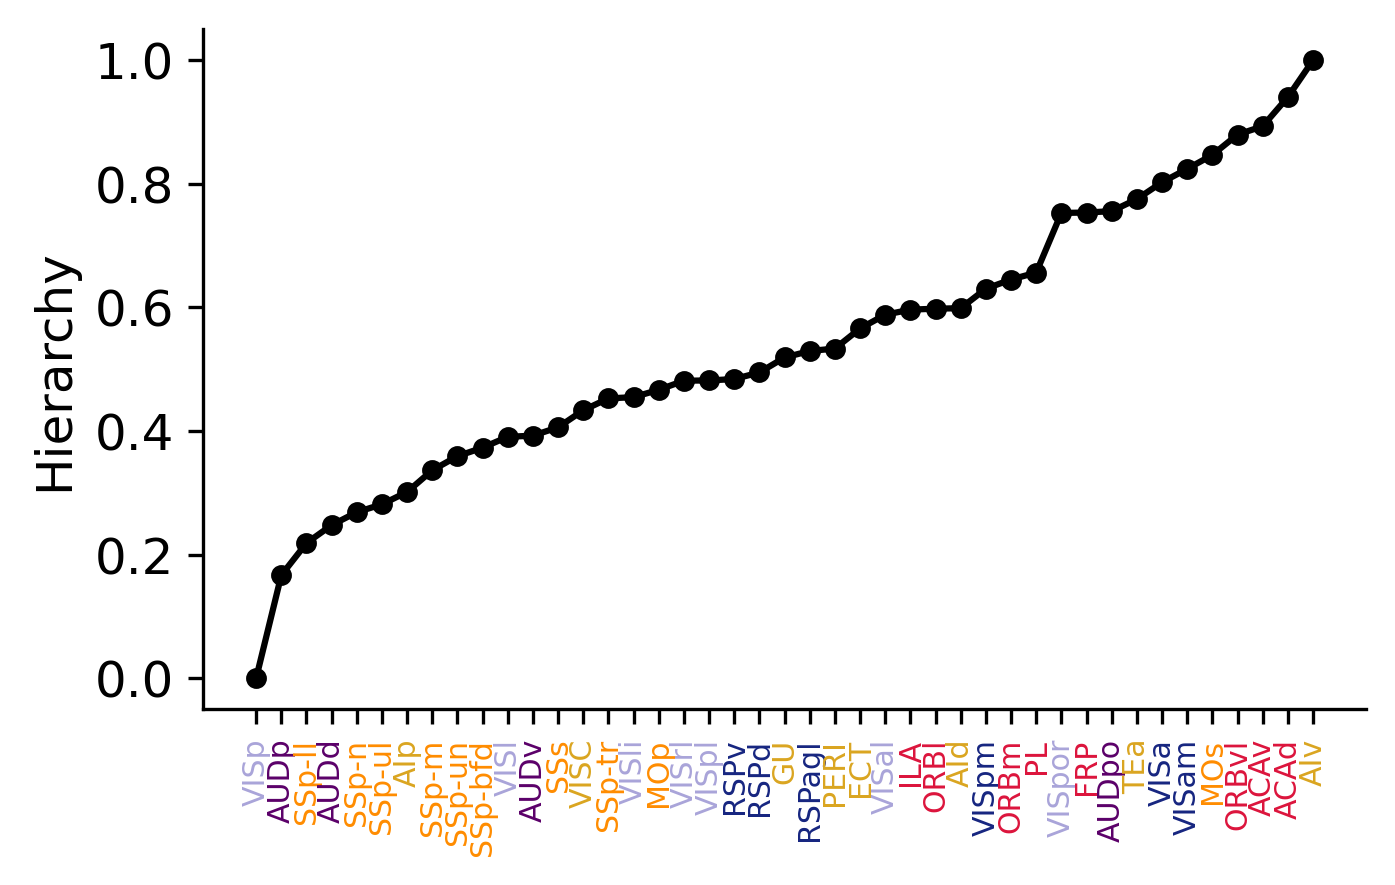

In [46]:
plotHiernotebook(hierarchy_df, 8, r'Hierarchy', (5,3), 12, True, 'loadDataProcessing/hierarchyPlotnotebook.svg')

In [48]:
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import brian2
import pickle
import networkx as nx
import copy
import seaborn as sns
from plotFunc import plotPaperTag, getConnHist, getNnodeLoop, plotXYcompr, plotXYcomprCorr, plotXYcomprResidual

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

from adjustText import adjust_text
# import statsmodels.api as sm

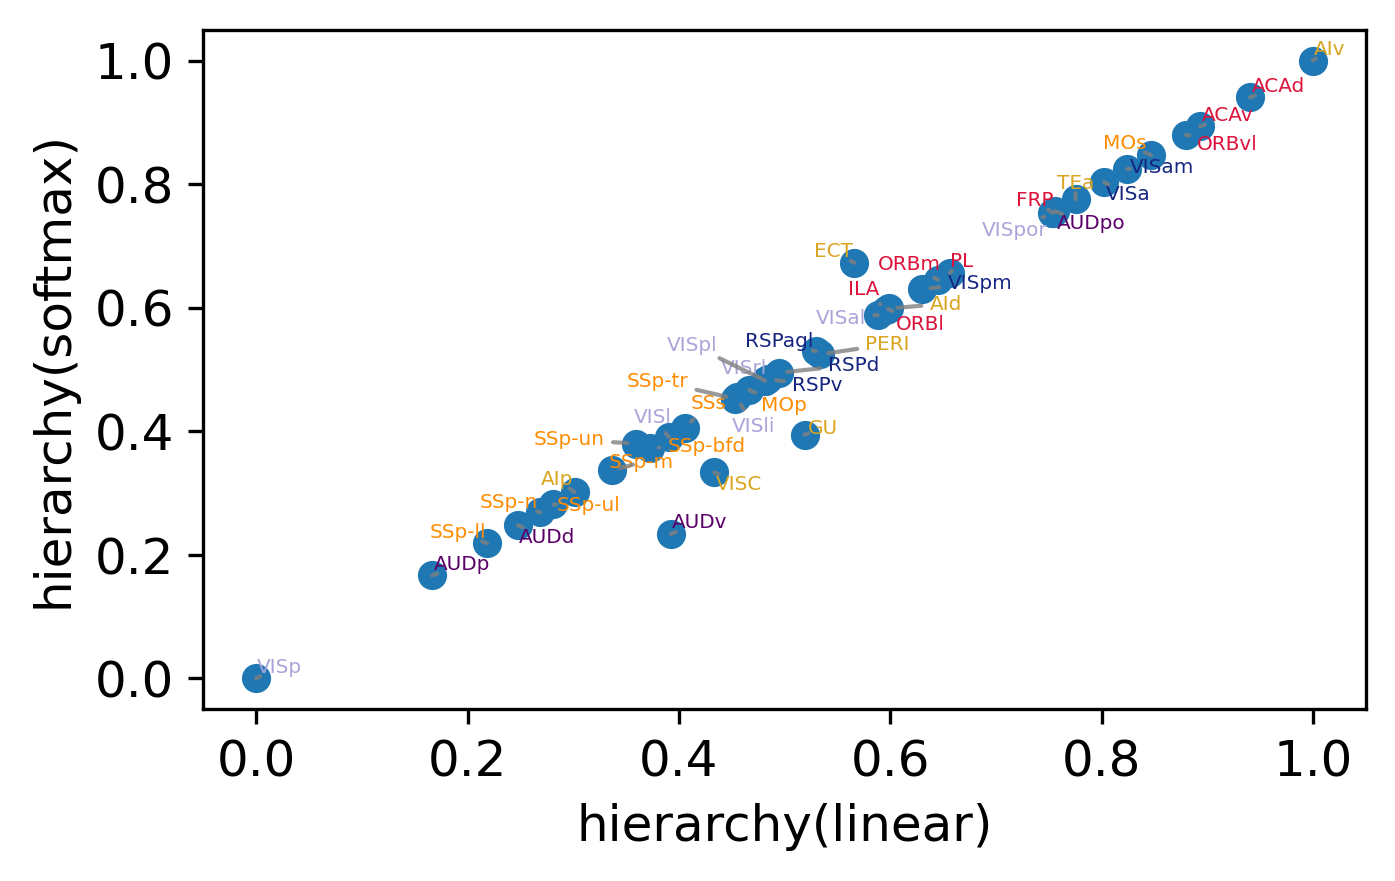

In [49]:
plt.figure(figsize=(5, 3),dpi=300)
plt.scatter(hierarchy, hierarchyEXP)
plt.xlabel('hierarchy(linear)')
plt.ylabel('hierarchy(softmax)')
fontSize = 12
ax = plt.gca()
texts = []
for i in range(len(area_list)):
    acr = area_list[i]
    for div_name, div_color in zip(div_name_list, div_color_list):
        if acr in div[div_name]:
            texts += [ax.text(hierarchy[i], hierarchyEXP[i], acr,
                              color=div_color, fontsize=fontSize*0.4)]

# # use adjust library to adjust the position of annotations.
if True:
    adjust_text(texts, hierarchy, hierarchyEXP,
                ax=ax, precision=0.001,
                arrowprops=dict(arrowstyle='-', color='gray', alpha=.8))

In [42]:
# from scipy.stats import linregress
# # linregress(a, b)
# i = 8
# print(area_list[i])
# plt.plot(conn_cxcx[i, :]) # input
# plt.figure()
# plt.plot(conn_cxcx[:, i]) # output
# np.exp(1e4*conn_cxcx[i, :]) / sum(np.exp(1e4*conn_cxcx[i, :]))
# np.power(conn_cxcx[i, :], 1/2)

# allhierPred, allhierPred2 = [], []
# for i in range(n_areas):
# #     hPred = sum(np.power(conn_cxcx[i, :], 3) * hierarchy.T.squeeze()) / sum(np.power(conn_cxcx[i, :], 3))
#     hPred = sum(np.exp(1e4 * conn_cxcx[i, :]) * hierarchy.T.squeeze()) / sum(np.exp(1e4 * conn_cxcx[i, :]))
# #     hPred = sum(conn_cxcx[i, :] * hierarchy.T.squeeze()) / sum(conn_cxcx[i, :])
#     hPred2 = sum(conn_cxcx[:, i]**1 * hierarchy.T.squeeze()) / sum(conn_cxcx[:, i]**1)
#     allhierPred.append(hPred)
#     allhierPred2.append(hPred2)
    
# allhierPred = np.array(allhierPred)
# allhierPred2 = np.array(allhierPred2)
# Yhier = hierarchy.T.squeeze()

# plt.figure()
# plt.scatter(allhierPred, Yhier)
# r1, p1 = sp.stats.pearsonr(allhierPred, Yhier)
# lg = linregress(allhierPred, Yhier)
# plt.title(str(r1))
# plt.xlabel('prediction hi')
# plt.ylabel('real hi')
# plt.xlim(0, 1)


# plt.figure()
# plt.scatter(allhierPred2, Yhier)
# r, p = sp.stats.pearsonr(allhierPred2, Yhier)
# plt.title(str(r))
# plt.xlabel('prediction hi')
# plt.ylabel('real hi')
# plt.xlim(0, 1)

In [43]:
# make plot using densityNorm connectivity. 

In [50]:
sym_cxcx = 0.5 * (conn_cxcx + conn_cxcx.T)
anti_cxcx = 0.5 * (conn_cxcx - conn_cxcx.T)
sym = (norm(sym_cxcx) - norm(anti_cxcx)) / (norm(sym_cxcx) + norm(anti_cxcx))
print(sym) # if sym ==1 or -1, then conn_cxcx is symmetric. 
px.imshow(sym_cxcx, color_continuous_scale='viridis')
# conn_cxcx_norm
sym_cxcx_norm = 0.5 * (conn_cxcx_norm + conn_cxcx_norm.T)
px.imshow(sym_cxcx_norm, color_continuous_scale='viridis')

0.6739922416377906


0.000237166113644883
0.00014483379983929552


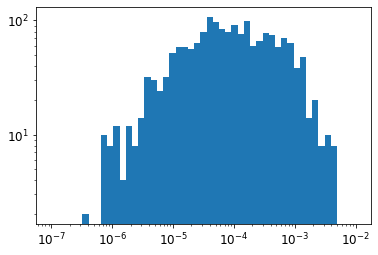

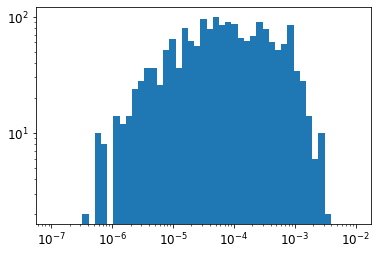

In [51]:
plt.figure()
plt.hist(sym_cxcx[sym_cxcx != 0], bins=np.logspace(np.log10(1e-7),np.log10(1e-2), 50), log=True)
ax = plt.gca()
ax.set_xscale('log')
# plt.figure()
# plt.hist(conn_cxcx[conn_cxcx != 0], bins=np.logspace(np.log10(1e-7),np.log10(1e-2), 50), log=True)
# ax = plt.gca()
# ax.set_xscale('log')
# plt.figure()
# plt.hist(conn_cxcx_norm[conn_cxcx_norm != 0], 
#          bins=np.logspace(np.log10(1e-7),np.log10(1e-2), 50), log=True)
# ax = plt.gca()
# ax.set_xscale('log')
plt.figure()
plt.hist(sym_cxcx_norm[sym_cxcx_norm != 0], 
         bins=np.logspace(np.log10(1e-7),np.log10(1e-2), 50), log=True)
ax = plt.gca()
ax.set_xscale('log')


# use the percentile

print(np.percentile(sym_cxcx, 70))
print(np.percentile(sym_cxcx_norm, 65))

In [52]:
# generate a graph for the connectivity
# https://github.com/rweng18/midsummer_network
conn_graph = nx.Graph()
for area in area_list_sort:
    conn_graph.add_node(area, size = 2)
conn_graph.nodes()

NodeView(('ACAd', 'ACAv', 'AId', 'AIp', 'AIv', 'AUDd', 'AUDp', 'AUDpo', 'AUDv', 'ECT', 'FRP', 'GU', 'ILA', 'MOp', 'MOs', 'ORBl', 'ORBm', 'ORBvl', 'PERI', 'PL', 'RSPagl', 'RSPd', 'RSPv', 'SSp-bfd', 'SSp-ll', 'SSp-m', 'SSp-n', 'SSp-tr', 'SSp-ul', 'SSp-un', 'SSs', 'TEa', 'VISC', 'VISa', 'VISal', 'VISam', 'VISl', 'VISli', 'VISp', 'VISpl', 'VISpm', 'VISpor', 'VISrl'))

In [53]:
# thresholding the network
threshold = 3.21e-4
conn_cxcx_thres = sym_cxcx * (sym_cxcx > threshold)
# add edges to the graph
for area1_index in range(len(area_list_sort)):
    for area2_index in range(len(area_list_sort)):
        if area1_index > area2_index:
            continue
        area1 = area_list_sort[area1_index]
        area2 = area_list_sort[area2_index]
        conn = conn_cxcx_thres[area1_index, area2_index]
        if conn > 0:
            conn_graph.add_edge(
            area1, area2, weight = conn)
  

In [55]:
# generate position for each node

pos_ = nx.spring_layout(conn_graph)
# 
brainCord = pd.read_csv('brainmapCord.csv')

c1 = np.cos(-0.95)
s1 = np.sin(-0.95)

for area in pos_:
    targetRow = brainCord[brainCord['area'] == area]
# print(targetRow)
    xcord = np.float(targetRow['xcord'])
    ycord = np.float(targetRow['ycord'])
    xcord_ = xcord * c1 - ycord * s1
    ycord_ = xcord * s1 + ycord * c1
    pos_[area] = np.array([xcord_, ycord_])

# pos_['AIp'] = [16, 5]
pos_['MOp'][1] = -5

In [56]:
def make_edge(x, y, text, width):
    
    '''Creates a scatter trace for the edge between x's and y's with given width

    Parameters
    ----------
    x    : a tuple of the endpoints' x-coordinates in the form, tuple([x0, x1, None])
    
    y    : a tuple of the endpoints' y-coordinates in the form, tuple([y0, y1, None])
    
    width: the width of the line

    Returns
    -------
    An edge trace that goes between x0 and x1 with specified width.
    '''
    return  go.Scatter(x         = x,
                       y         = y,
                       line      = dict(width = width,
                                   color = 'cornflowerblue'),
                       opacity = 0.5,
                       hoverinfo = 'text',
                       text      = ([text]),
                       mode      = 'lines')

In [57]:
def weight2thick(wgt, threshold):
    return np.log10(wgt) - np.log10(threshold)

In [58]:
# For each edge, make an edge_trace, append to list

edge_trace = []
for edge in conn_graph.edges():
    wgt = conn_graph.edges()[edge]['weight']
    if wgt > 0:
        area1 = edge[0]
        area2 = edge[1]

        x0, y0 = pos_[area1]
        x1, y1 = pos_[area2]

        text   = area1 + '--' + area2 + ': ' + str(wgt)
        
        trace  = make_edge(
            [x0, x1, None], [y0, y1, None], text,
            weight2thick(wgt, threshold) * 2 + 0.5)
        edge_trace.append(trace)

In [59]:
 # Make a node trace
node_trace = go.Scatter(x         = [],
                        y         = [],
                        text      = [],
                        textposition = "top center",
                        textfont_size = 5,
                        mode      = 'markers+text',
                        hoverinfo = 'none',
                        marker    = dict(color = [],
                                         size  = [],
                                         line  = None))
# For each node, get the position and size and add to the node_trace
for node in conn_graph.nodes():
    x, y = pos_[node]
    node_trace['x'] += tuple([x])
    node_trace['y'] += tuple([y])
    node_trace['marker']['color'] += tuple(['cornflowerblue'])
    node_trace['marker']['size'] += tuple([5*conn_graph.nodes()[node]['size']])
    node_trace['text'] += tuple(['<b>' + node + '</b>'])

[0.20118983]


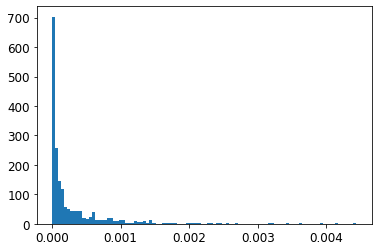

In [60]:
# get the range for thresholding the network.
a  = sym_cxcx.reshape(-1,1)
plt.hist(a, bins = 100)
print(sum(a > 4.2e-4)/len(a)) 


conn_graph = nx.Graph()
for area in area_list_sort:
    conn_graph.add_node(area, size = 2)
conn_graph.nodes()

# thresholding the network
threshold = 2.9e-4
conn_cxcx_thres = sym_cxcx * (sym_cxcx > threshold)
# add edges to the graph
for area1_index in range(len(area_list_sort)):
    for area2_index in range(area1_index+1, len(area_list_sort)):
        area1 = area_list_sort[area1_index]
        area2 = area_list_sort[area2_index]
        conn = conn_cxcx_thres[area1_index, area2_index]
        if conn > 0:
            conn_graph.add_edge(
            area1, area2, weight = conn)

# For each edge, make an edge_trace, append to list

edge_trace = []
for edge in conn_graph.edges():
    wgt = conn_graph.edges()[edge]['weight']
    if wgt > 0:
        area1 = edge[0]
        area2 = edge[1]

        x0, y0 = pos_[area1]
        x1, y1 = pos_[area2]

        text   = area1 + '--' + area2 + ': ' + str(wgt)
        
        trace  = make_edge(
            [x0, x1, None], [y0, y1, None], text,
            weight2thick(wgt, threshold) * 2 + 0.5)
        edge_trace.append(trace)
        
# Make a node trace
node_trace = go.Scatter(x         = [],
                        y         = [],
                        text      = [],
                        textposition = "top center",
                        textfont_size = 5,
                        mode      = 'markers+text',
                        hoverinfo = 'none',
                        marker    = dict(color = [],
                                         size  = [],
                                         line  = None))
# For each node, get the position and size and add to the node_trace
for node in conn_graph.nodes():
    x, y = pos_[node]
    node_trace['x'] += tuple([x])
    node_trace['y'] += tuple([y])
    node_trace['marker']['color'] += tuple(['cornflowerblue'])
    node_trace['marker']['size'] += tuple([5*conn_graph.nodes()[node]['size']])
    node_trace['text'] += tuple(['<b>' + node + '</b>'])        


layout = go.Layout(
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)'
)

saveFig = True
fileName = 'rawConnectivityMap.svg'

fig = go.Figure(layout = layout)

for trace in edge_trace:
    fig.add_trace(trace)

fig.add_trace(node_trace)

fig.update_layout(showlegend = False)

fig.update_xaxes(showticklabels = False, automargin=True)

fig.update_yaxes(showticklabels = False, scaleanchor='x', scaleratio=1, automargin=True)
fig.update_layout(width = 700, height=580)
fig.show()
if saveFig:
    fig.write_image("figure/loadDataProcessing/"+ fileName, width=700, height=580, scale=1)
# py.plot(fig, filename='conn_graph.html')

In [61]:
conn_graph = nx.Graph()
for area in area_list_sort:
    conn_graph.add_node(area, size = 2)
conn_graph.nodes()

# thresholding the network
threshold = 4.2e-4 #2.9e-4
conn_cxcx_thres = sym_cxcx * (sym_cxcx > threshold)
# add edges to the graph
for area1_index in range(len(area_list_sort)):
    for area2_index in range(area1_index+1, len(area_list_sort)):
        area1 = area_list_sort[area1_index]
        area2 = area_list_sort[area2_index]
        conn = conn_cxcx_thres[area1_index, area2_index]
        if conn > 0:
            conn_graph.add_edge(
            area1, area2, weight = conn)

# For each edge, make an edge_trace, append to list

edge_trace = []
for edge in conn_graph.edges():
    wgt = conn_graph.edges()[edge]['weight']
    if wgt > 0:
        area1 = edge[0]
        area2 = edge[1]

        x0, y0 = pos_[area1]
        x1, y1 = pos_[area2]

        text   = area1 + '--' + area2 + ': ' + str(wgt)
        
        trace  = make_edge(
            [x0, x1, None], [y0, y1, None], text,
            weight2thick(wgt, threshold) * 2 + 0.5)
        edge_trace.append(trace)
        
# Make a node trace
node_trace = go.Scatter(x         = [],
                        y         = [],
                        text      = [],
                        textposition = "top center",
                        textfont_size = 8,
                        mode      = 'markers+text',
                        hoverinfo = 'none',
                        marker    = dict(color = [],
                                         size  = [],
                                         line  = None))
# For each node, get the position and size and add to the node_trace
for node in conn_graph.nodes():
    x, y = pos_[node]
    node_trace['x'] += tuple([x])
    node_trace['y'] += tuple([y])
    node_trace['marker']['color'] += tuple(['cornflowerblue'])
    node_trace['marker']['size'] += tuple([5*conn_graph.nodes()[node]['size']])
    node_trace['text'] += tuple(['<b>' + node + '</b>'])        


layout = go.Layout(
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)'
)

saveFig = True
fileName = 'rawConnectivityMap.svg'

fig = go.Figure(layout = layout)

for trace in edge_trace:
    fig.add_trace(trace)

fig.add_trace(node_trace)

fig.update_layout(showlegend = False)

fig.update_xaxes(showticklabels = False, automargin=True)

fig.update_yaxes(showticklabels = False, scaleanchor='x', scaleratio=1, automargin=True)
fig.update_layout(width = 700, height=580)
fig.show()
if saveFig:
    fig.write_image("figure/loadDataProcessing/"+ fileName, width=700, height=580, scale=1)
# py.plot(fig, filename='conn_graph.html')

[0.20118983]


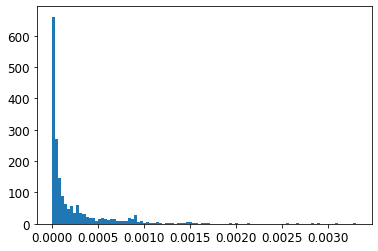

In [62]:
# get the range for thresholding the network.
a  = sym_cxcx_norm.reshape(-1,1)
plt.hist(a, bins = 100)
print(sum(a > 3.5e-4)/len(a)) 

In [63]:
# generate a graph for the connectivity
# https://github.com/rweng18/midsummer_network

saveFig = True
fileName = 'connectivityNormalized.svg'

conn_graph = nx.Graph()
for area in area_list_sort:
    conn_graph.add_node(area, size = 2)
conn_graph.nodes()

# thresholding the network
threshold = 3.5e-4  #1.6e-4
conn_cxcx_norm_thres = sym_cxcx_norm * (sym_cxcx_norm > threshold)
# add edges to the graph
for area1_index in range(len(area_list_sort)):
    for area2_index in range(area1_index+1, len(area_list_sort)):

        area1 = area_list_sort[area1_index]
        area2 = area_list_sort[area2_index]
        conn = conn_cxcx_norm_thres[area1_index, area2_index]
        if conn > 0:
            conn_graph.add_edge(
            area1, area2, weight = conn)
            
# For each edge, make an edge_trace, append to list

edge_trace = []
for edge in conn_graph.edges():
    wgt = conn_graph.edges()[edge]['weight']
    if wgt > 0:
        area1 = edge[0]
        area2 = edge[1]

        x0, y0 = pos_[area1]
        x1, y1 = pos_[area2]

        text   = area1 + '--' + area2 + ': ' + str(wgt)
        
        trace  = make_edge(
            [x0, x1, None], [y0, y1, None], text,
            weight2thick(wgt, threshold) * 2 + 0.5)
        edge_trace.append(trace)
        
        
# Make a node trace
node_trace = go.Scatter(x         = [],
                        y         = [],
                        text      = [],
                        textposition = "top center",
                        textfont_size = 8,
                        mode      = 'markers+text',
                        hoverinfo = 'none',
                        marker    = dict(color = [],
                                         size  = [],
                                         line  = None))
# For each node, get the position and size and add to the node_trace
for node in conn_graph.nodes():
    x, y = pos_[node]
    node_trace['x'] += tuple([x])
    node_trace['y'] += tuple([y])
    node_trace['marker']['color'] += tuple(['cornflowerblue'])
    node_trace['marker']['size'] += tuple([5*conn_graph.nodes()[node]['size']])
    node_trace['text'] += tuple(['<b>' + node + '</b>'])   
    
    
    

    layout = go.Layout(
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)'
)



fig = go.Figure(layout = layout)

for trace in edge_trace:
    fig.add_trace(trace)

fig.add_trace(node_trace)

fig.update_layout(showlegend = False)

fig.update_xaxes(showticklabels = False)

fig.update_yaxes(showticklabels = False, scaleanchor='x', scaleratio=1)
fig.update_layout(width = 700, height=580)
fig.show()
if saveFig:
    fig.write_image("figure/loadDataProcessing/"+ fileName, width=700, height=580, scale=1)
# py.plot(fig, filename='conn_graph.html')

In [64]:
inDegree, outDegree = [], []
thresIn, thresOut = 2.75e-4, 2.75e-4
for i in range(len(area_list)):
    inDegree.append(sum(conn_cxcx_norm[i, :] > thresIn))
    outDegree.append(sum(conn_cxcx_norm[:, i] > thresOut))
df = pd.DataFrame({'area': area_list, 'inDegree': inDegree, 'outDegree': outDegree})
fig = px.line(df, 'area', ['inDegree', 'outDegree'])
fig.update_yaxes(title='degree')
fig.update_layout(legend_title_text='')
fig.show()
fig.write_image("figure/loadDataProcessing/"+ "inOutDegree.svg", width=1000, height=380, scale=1)

In [65]:
# use 75% to determine threshold.
print(np.percentile(sym_cxcx_norm, 75))
print(np.percentile(sym_cxcx, 75))

0.00027518874499489845
0.00032097227795097256


In [66]:
def makeHeatPlotRect(mat, xTicks, yTicks, Xlabel, Ylabel, cbarlabel, colormap, figureSize, fontSize, saveFig, fileName):
    fig = plt.figure(figsize=figureSize, dpi=300, facecolor='w', edgecolor='k')
    plt.rcParams.update({'font.size': fontSize})
#     plt.imshow(mat, colormap, norm=TwoSlopeNorm(0))
    plt.imshow(mat, colormap)
    cbar = plt.colorbar()
    cbar.set_label(cbarlabel)
    plt.xticks(range(len(xTicks)), xTicks, rotation=90, fontsize=fontSize*0.4)
    plt.yticks(range(len(yTicks)), yTicks, fontsize=fontSize*0.4)
    plt.xlabel(Xlabel)
    plt.ylabel(Ylabel)
    
    # save figure
    if saveFig:
        plt.savefig('figure/' + fileName, dpi=300, bbox_inches='tight', transparent=True)
    # plt.savefig('figure/neurondensity_grad.png',dpi=80,bbox_inc

['VISp', 'AUDp', 'SSp-ll', 'AUDd', 'SSp-n'] 43
[[0.00000000e+00 1.34948665e-04 8.34080166e-06 ... 7.12760164e-05
  1.22978703e-04 8.01495825e-07]
 [4.15868936e-05 0.00000000e+00 1.82186338e-05 ... 5.62982966e-06
  1.73370336e-05 4.54257602e-07]
 [2.54424327e-05 5.77353349e-05 0.00000000e+00 ... 5.64913807e-05
  2.59509999e-04 3.50630984e-06]
 ...
 [9.85171744e-05 1.27480720e-05 1.96933547e-05 ... 0.00000000e+00
  2.03076057e-03 6.61068928e-06]
 [2.33281908e-04 4.22517398e-05 1.17127609e-04 ... 3.33649497e-03
  0.00000000e+00 4.22098998e-05]
 [6.94814042e-06 1.64121187e-05 5.16031619e-06 ... 6.49492213e-05
  1.22779772e-04 0.00000000e+00]]


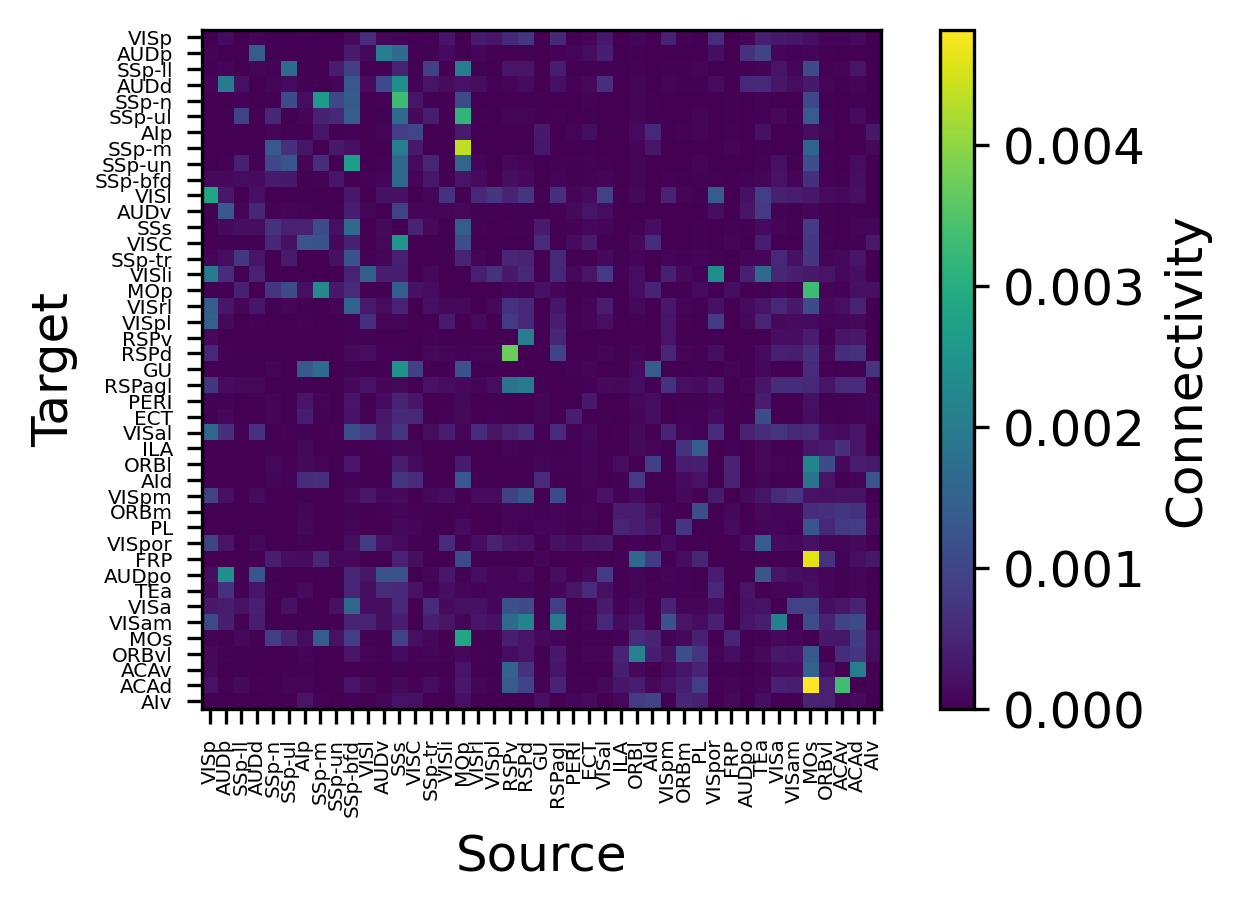

In [67]:
# rearrange the connnectivity to be hierarhchical. 
sortedAreaList = [area_list[i] for i in np.argsort(list(hierarchy_df['hierarchy index']))]
print(sortedAreaList[:5], len(sortedAreaList))

sortedConnPre = np.array( [conn_cxcx_norm[:,j].tolist() for j in np.argsort(list(hierarchy_df['hierarchy index']))] )
sortedConn = np.array( [sortedConnPre[:,i].tolist() for i in np.argsort(list(hierarchy_df['hierarchy index']))] )

print(sortedConn)

makeHeatPlotRect(sortedConn, sortedAreaList, sortedAreaList,
                'Source', 'Target', 'Connectivity', 'viridis', (5, 3), 12, True, 'loadDataProcessing/cortexConnectivityMatrix.svg')

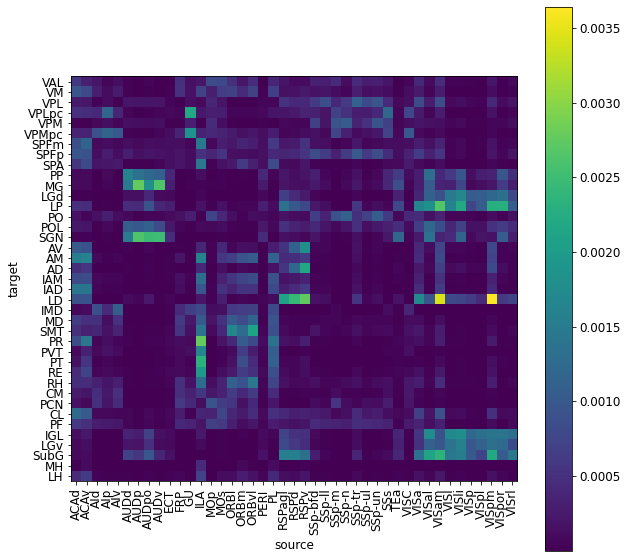

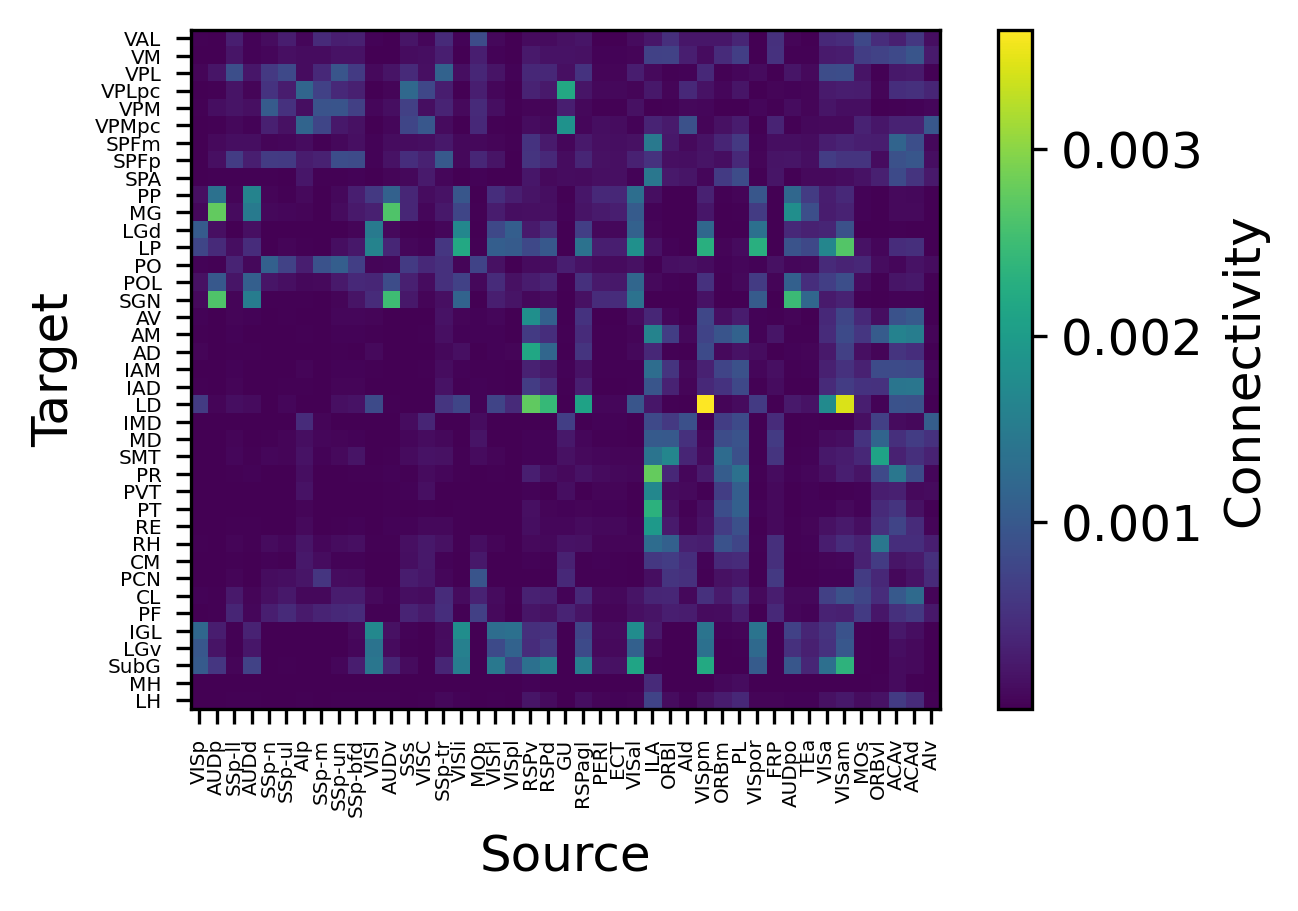

In [68]:
sortedconncxth = np.array( [conn_cxth[:,j].tolist() for j in np.argsort(list(hierarchy_df['hierarchy index']))] ).T
# sortedConn = np.array( [sortedConnPre[:,i].tolist() for i in np.argsort(list(hierarchy_df['hierarchy index']))] )
# TODO: check the order of the connectivity
#  unfinished sorted CXTH connections. 
plt.figure(figsize=(10,10))
plt.imshow(conn_cxth)
plt.xticks(range(len(area_list)), area_list, rotation=90)
plt.yticks(range(len(thal_acr)), thal_acr)
plt.xlabel('source')
plt.ylabel('target')
plt.colorbar()

makeHeatPlotRect(sortedconncxth, sortedAreaList, thal_acr,
                'Source', 'Target', 'Connectivity', 'viridis', (5, 3), 12, True, 'loadDataProcessing/cxthConnectivityMatrix.svg')





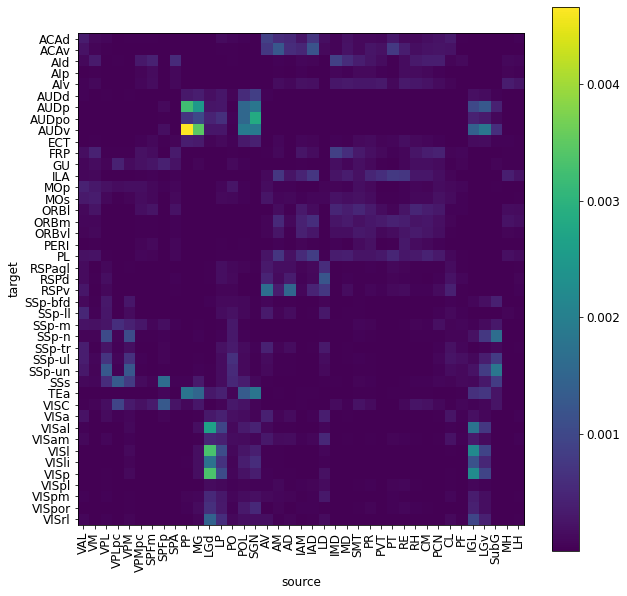

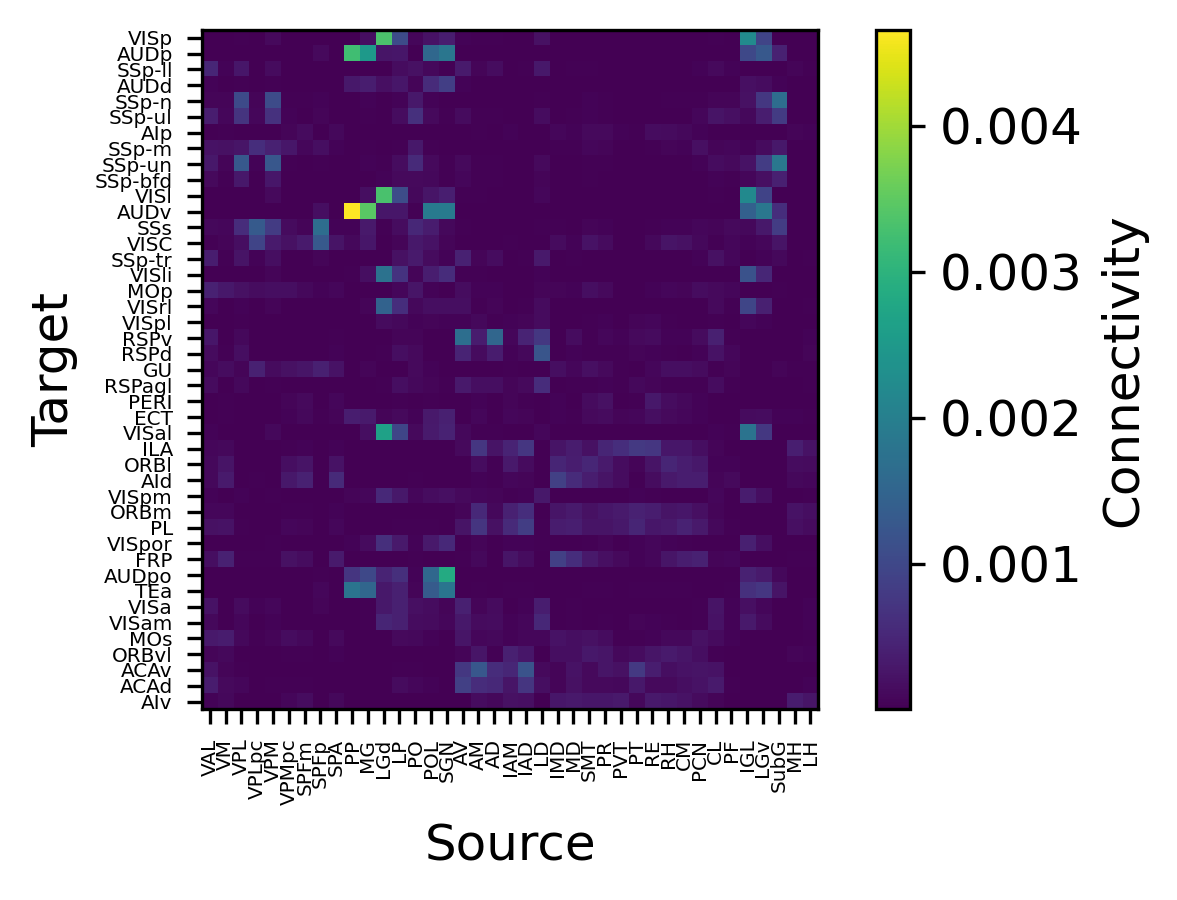

In [69]:
sortedconnthcx = np.array( [conn_thcx[i,:].tolist() for i in np.argsort(list(hierarchy_df['hierarchy index']))] )

plt.figure(figsize=(10,10))
plt.imshow(conn_thcx)
plt.yticks(range(len(area_list)), area_list)
plt.xticks(range(len(thal_acr)), thal_acr, rotation=90)
plt.xlabel('source')
plt.ylabel('target')
plt.colorbar()

makeHeatPlotRect(sortedconnthcx, thal_acr, sortedAreaList,
                'Source', 'Target', 'Connectivity', 'viridis', (5, 3), 12, True, 'loadDataProcessing/thcxConnectivityMatrix.svg')


In [70]:
# save arealist
np.savetxt("results/area_list.csv", sortedAreaList, delimiter=",", fmt = '%s')
# check if loading area list works
arr = np.loadtxt('results/area_list.csv', delimiter=',', dtype='str')
arr[0:5]

array(['VISp', 'AUDp', 'SSp-ll', 'AUDd', 'SSp-n'], dtype='<U7')

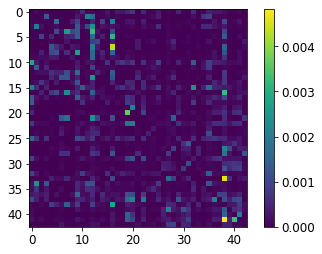

In [71]:
plt.imshow(sortedConn)
plt.colorbar()

In [72]:
# save connectivity
np.savetxt("results/conn_cxcx.csv", sortedConn, delimiter=",")
np.savetxt("results/conn_cxth.csv", sortedconncxth, delimiter=",")
np.savetxt("results/conn_thcx.csv", sortedconnthcx, delimiter=",")

np.savetxt("results/conn_cxcx_raw.csv", conn_cxcx, delimiter=",")


volume_df.to_csv('results/dfVolume.csv')
density_df.to_csv("results/dfDensity.csv")

# np.savetxt("results/dfDensity.csv", density_df, delimiter=",")

In [73]:
arr = np.loadtxt('results/conn_cxcx.csv', delimiter=',')
print(arr[0:5, 0:5])
print(arr.shape)

[[0.00000000e+00 1.34948665e-04 8.34080166e-06 6.91952651e-05
  1.65061332e-06]
 [4.15868936e-05 0.00000000e+00 1.82186338e-05 1.39309282e-03
  3.21421163e-05]
 [2.54424327e-05 5.77353349e-05 0.00000000e+00 7.19036339e-05
  5.37521762e-05]
 [7.50510248e-05 1.97600517e-03 2.12738225e-04 0.00000000e+00
  8.41193600e-05]
 [3.52494304e-06 5.04174152e-06 4.21113209e-05 1.12002904e-05
  0.00000000e+00]]
(43, 43)


In [74]:
# load interneuron density 
# and add processing afterwards. 

interneuronfilename = 'mouse_interneuron_density.pkl'
celldensityfilename = 'cell_density_iso.csv'
# get density for related old areas (the area name is based on CCF v2, not latest CCF v3)
old_areas = ['ACAd', 'ACAv', 'AId', 'AIp', 'AIv', 'AUDd', 'AUDp','AUDpo', 'AUDv', 'ECT', 'GU',
'ILA', 'MOp', 'MOs', 'ORBl', 'ORBm', 'ORBvl', 'PERI', 'PL', 'PTLp', 'RSPagl', 'RSPd',
'RSPv', 'SSp-bfd', 'SSp-ll', 'SSp-m', 'SSp-n', 'SSp-tr', 'SSp-ul', 'SSs', 'TEa', 'VISC', 
'VISal', 'VISam', 'VISl', 'VISp', 'VISpl', 'VISpm']

neurons_sorted = load_celldensity(libfilepath, celldensityfilename, old_areas)
 
[PVgrad_df, SSTgrad_df, normPVgrad_df, normSSTgrad_df] = load_interneurondensity(
    libfilepath, interneuronfilename, old_areas)

# modify cell density
# neurons_sorted[37] = neurons_sorted[33] # VISpm seems outlier, replace it with VISam

# load pandas dataframe "results/dfDensity.csv"
density_df = pd.read_csv("results/dfDensity.csv", index_col=0)

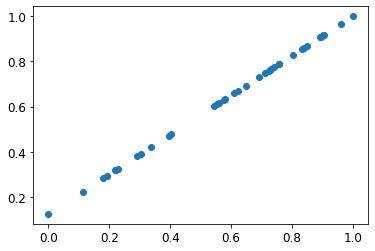

In [75]:
a = np.array(list(PVgrad_df['raw PV density']))
r1 = (a - min(a)) / (max(a) - min(a))
r2 = a / max(a)
plt.scatter(r1, r2)

In [76]:
len(neurons_sorted)
print(old_areas)

['ACAd', 'ACAv', 'AId', 'AIp', 'AIv', 'AUDd', 'AUDp', 'AUDpo', 'AUDv', 'ECT', 'GU', 'ILA', 'MOp', 'MOs', 'ORBl', 'ORBm', 'ORBvl', 'PERI', 'PL', 'PTLp', 'RSPagl', 'RSPd', 'RSPv', 'SSp-bfd', 'SSp-ll', 'SSp-m', 'SSp-n', 'SSp-tr', 'SSp-ul', 'SSs', 'TEa', 'VISC', 'VISal', 'VISam', 'VISl', 'VISp', 'VISpl', 'VISpm']


In [77]:

PVcellNorm = np.array(PVgrad_df)[:, 0] / neurons_sorted
PVcell_df = pd.DataFrame(PVcellNorm, columns=['raw PV density'], index=old_areas)
PVnormcellNorm = np.array(normPVgrad_df)[:, 0] / neurons_sorted 
PVnormcellNorm = PVnormcellNorm / PVnormcellNorm.max()
normPVcell_df = pd.DataFrame(PVnormcellNorm, columns=['norm PV gradient'], index=old_areas)

# SSTcell_df is the SST cell fraction. 
SSTcellNorm = np.array(SSTgrad_df)[:, 0] / neurons_sorted
SSTcell_df = pd.DataFrame(SSTcellNorm, columns=['raw SST density'], index=old_areas)
SSTcell_df

,raw SST density
ACAd,0.068899
ACAv,0.051616
AId,0.062699
AIp,0.061476
AIv,0.073648
AUDd,0.046923
AUDp,0.041616
AUDpo,0.049402
AUDv,0.044817
ECT,0.050551


In [78]:
areasInterest = ['SSp-bfd','VISp', 'MOs', 'PL', 'ILA']
print([PVcell_df['raw PV density'][A] for A in areasInterest])
print([SSTcell_df['raw SST density'][A] for A in areasInterest])

# SSp-bfd VIP: 0.071/2 = 0.0355 total: 0.071+0.056+0.0355 = 0.1625
# VISp VIP: 0.05*0.6 = 0.03 total: 0.051+0.05+0.03 = 0.131
# MOs VIP: 0.056/2 = 0.028   total: 0.056+0.061+0.028 = 0.145
# PL VIP: 0.02*1.3 = 0.026 total: 0.02+0.065+0.026 = 0.111
# ILA VIP: 0.021*0.8 = 0.0168 total: 0.021+0.089+0.0168 = 0.1268


[0.0716382975959487, 0.05129187889551597, 0.055939268759230484, 0.02037011195249871, 0.021112778908722995]
[0.05620061005926644, 0.05020351627468708, 0.06138177446132386, 0.06493562792845291, 0.08865549088601474]


2.2552321509407425 1.800822418396625


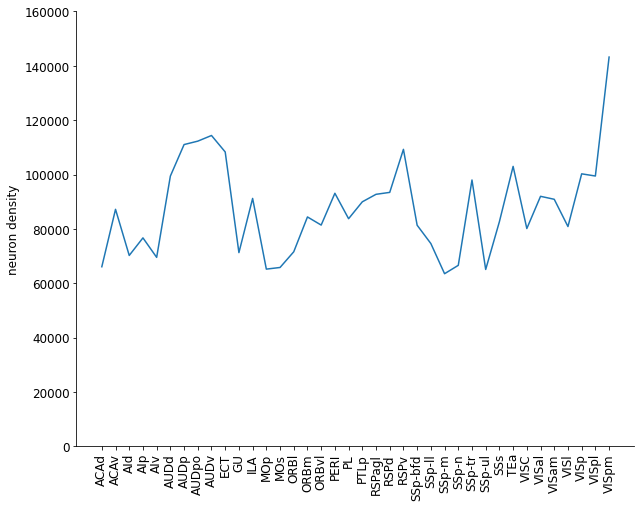

In [79]:
plt.figure(figsize=(10,8))
plt.plot(neurons_sorted)
plt.xticks(range(len(neurons_sorted)), old_areas, rotation = 90)
# plt.plot(sorted(neurons_sorted))
# sortIndex = np.argsort(neurons_sorted)
# plt.xticks(range(len(neurons_sorted)), [old_areas[i] for i in sortIndex], rotation = 90)
plt.ylabel('neuron density')
plt.ylim((0, 160000))
axes = plt.gca()
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
print(sorted(neurons_sorted)[-1] / sorted(neurons_sorted)[0], sorted(neurons_sorted)[-2] / sorted(neurons_sorted)[0])


In [80]:
# preprocessing the interneuron density
[PVgrad_df, SSTgrad_df, PVcell_df, normPVgrad_df, normSSTgrad_df, normPVcell_df] = interneuronDensityProcessing(
    [PVgrad_df, SSTgrad_df, PVcell_df, normPVgrad_df, normSSTgrad_df, normPVcell_df])

In [81]:
len(PVcell_df)

43

In [82]:
def plotRawDensitynotebook(grad_df, dotSize, yaxis, figureSize, fontSize, saveFig, fileName):
        # seaborn.set()
    dfRaw = grad_df.sort_values(grad_df.columns[0])

    fig = plt.figure(figsize = figureSize, dpi=300, facecolor='w', edgecolor='k')
    plt.rcParams.update({'font.size': fontSize})
    
    xx = np.arange(len(grad_df))
    plt.plot(xx, dfRaw.values, '.-', markersize=dotSize, color='k')
    plt.xticks(xx, dfRaw.index, rotation = 90, fontsize=fontSize*0.6)
    plt.ylabel(yaxis) #r'$e_i/e_1$'
    # regPV = sk.linear_model.LinearRegression()
    # xx2 = xx[np.newaxis].T
    # regPV.fit(xx2, dfRaw.values)
    # print(regPV.coef_, regPV.intercept_)
    # plt.plot(xx, xx * regPV.coef_[0][0] + regPV.intercept_[0], alpha = 0.5)
    ax = plt.gca()
#     [t.set_color('red') for t in ax.xaxis.get_ticklabels()]
    for t in ax.xaxis.get_ticklabels():
        label = t._text
        for i in range(6):
            if label in div[div_name_list[i]]:
                t.set_color(div_color_list[i])
    # plt.grid(alpha = 0.5)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if saveFig:
        plt.savefig('figure/' + fileName, dpi=300, bbox_inches='tight',transparent=True)

In [83]:
def plotDensityBasedOnRawPVnotebook(grad_df, dotSize, yaxis, figureSize, fontSize, saveFig, fileName):
        # seaborn.set()
    dfSort = grad_df.sort_values(by = 'raw PV density')
    

    fig = plt.figure(figsize = figureSize, dpi=300, facecolor='w', edgecolor='k')
    plt.rcParams.update({'font.size': fontSize})
    
    xx = np.arange(len(grad_df))
    plt.plot(xx, dfSort['neuron density'], '.-', markersize=dotSize, color='k')
    plt.xticks(xx, dfSort['area'], rotation = 90, fontsize=fontSize*0.6)
    plt.ylabel(yaxis) #r'$e_i/e_1$'
    # regPV = sk.linear_model.LinearRegression()
    # xx2 = xx[np.newaxis].T
    # regPV.fit(xx2, dfRaw.values)
    # print(regPV.coef_, regPV.intercept_)
    # plt.plot(xx, xx * regPV.coef_[0][0] + regPV.intercept_[0], alpha = 0.5)
    ax = plt.gca()
#     [t.set_color('red') for t in ax.xaxis.get_ticklabels()]
    for t in ax.xaxis.get_ticklabels():
        label = t._text
        for i in range(6):
            if label in div[div_name_list[i]]:
                t.set_color(div_color_list[i])
    # plt.grid(alpha = 0.5)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if saveFig:
        plt.savefig('figure/' + fileName, dpi=300, bbox_inches='tight',transparent=True)

In [84]:
# plot the cell density according to the order of raw PV density. 


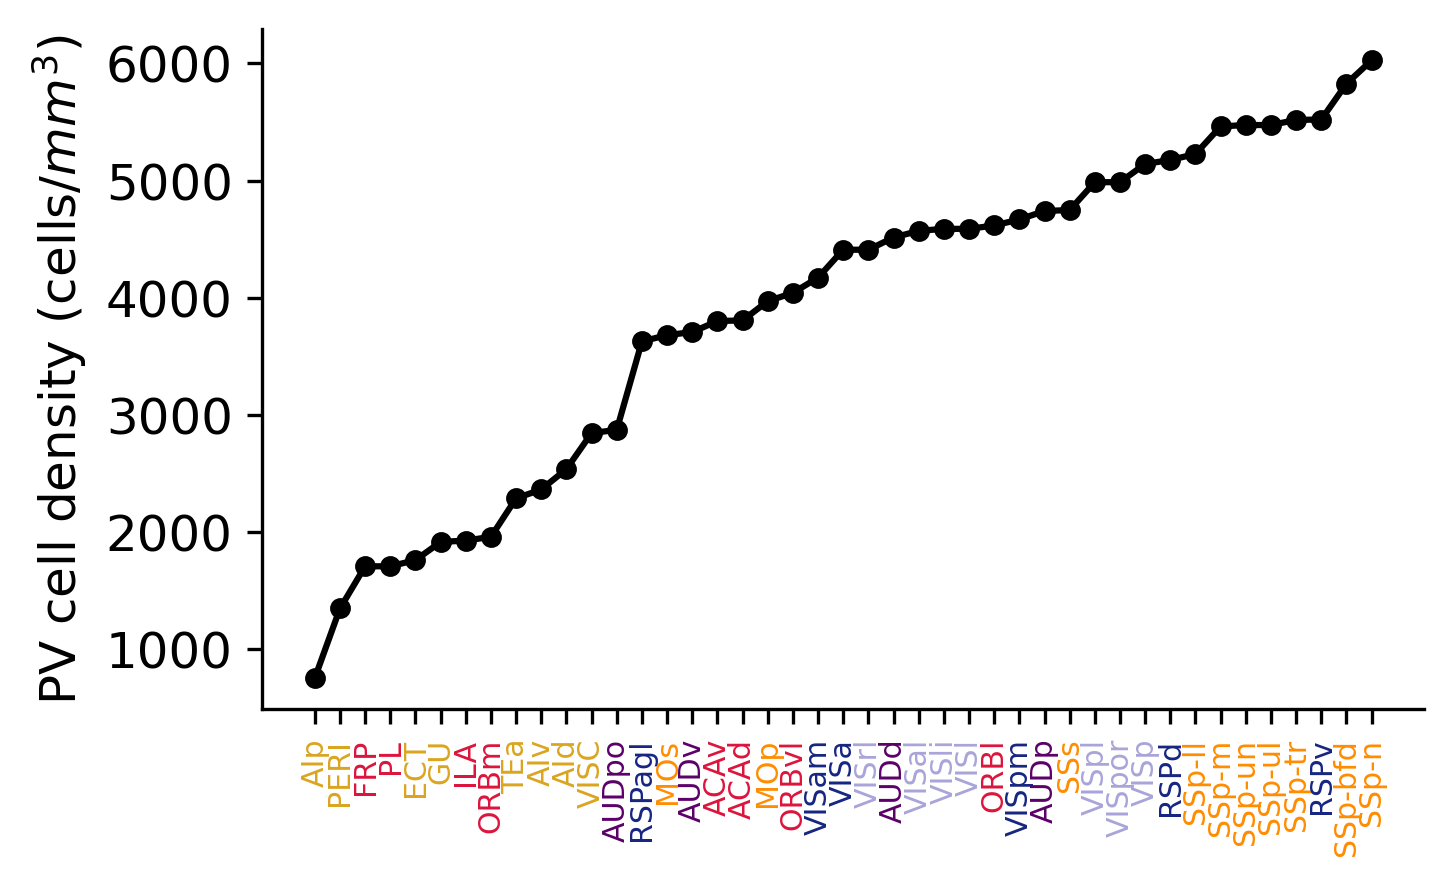

In [85]:
plotRawDensitynotebook(PVgrad_df, 8, r'PV cell density (cells/$mm^{3}$)', (5,3), 12, True, 'loadDataProcessing/rawPVnotebook.svg')

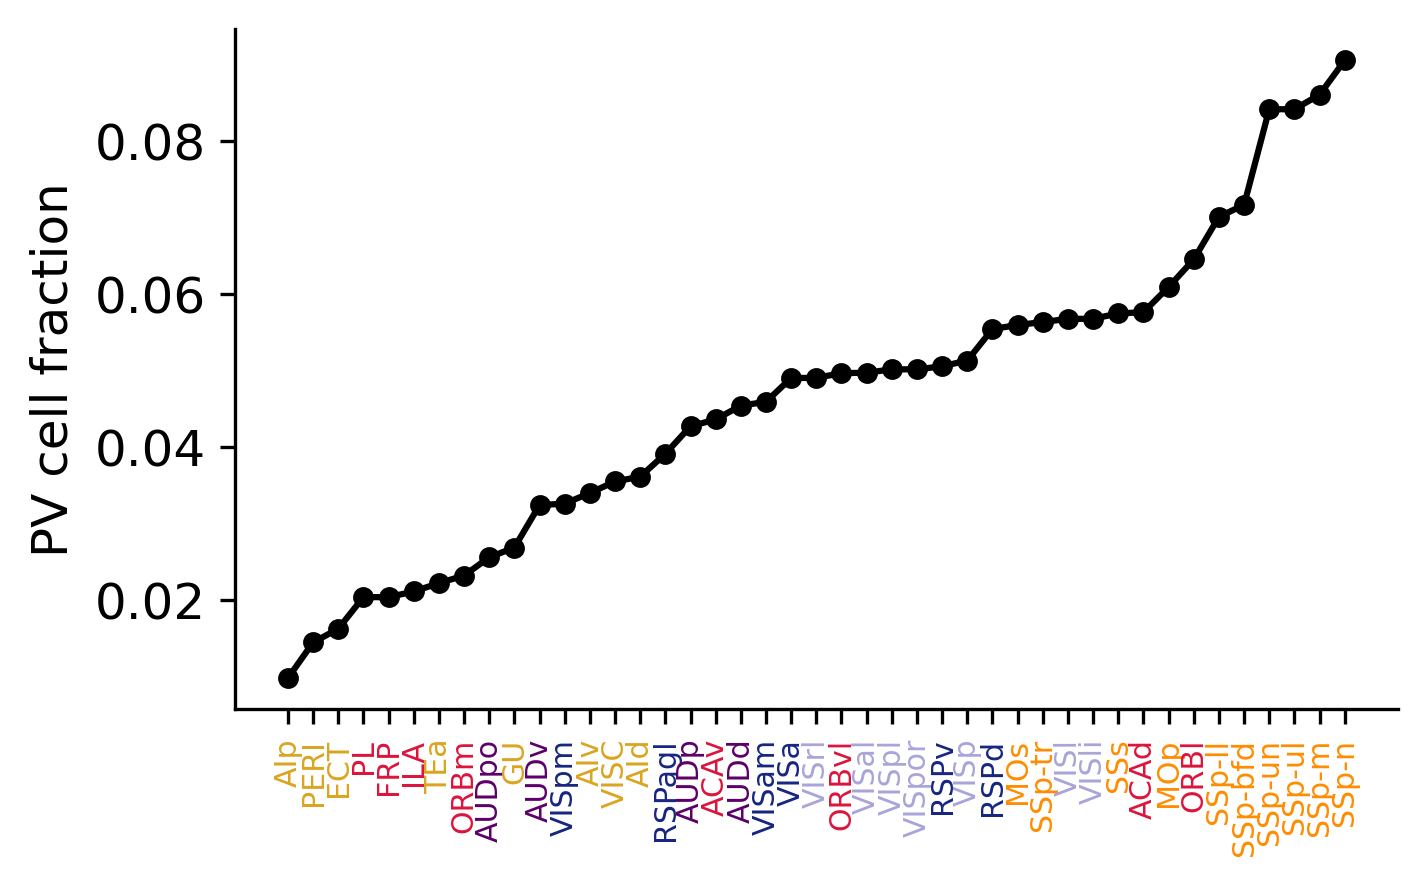

In [86]:
plotRawDensitynotebook(PVcell_df, 8, r'PV cell fraction', (5,3), 12, True, 'loadDataProcessing/ratioPVnotebook.svg')

In [87]:
# make a dataframe for neurondensity in density_df and raw pv density in PVgrad_df.
density_rawPV_df = pd.DataFrame({'area': list(density_df['area']), 'neuron density': list(density_df['neuron density']), 'raw PV density': list(PVgrad_df['raw PV density'])})
density_rawPV_df.head()

,area,neuron density,raw PV density
0,ACAd,66059.01898,3805.260784
1,ACAv,87184.88412,3800.469604
2,AId,70218.45077,2535.565615
3,AIp,76680.34983,751.207559
4,AIv,69508.04572,2361.815700


In [88]:
# sort the dataframe by raw PV density
dfSort = density_rawPV_df.sort_values(by = 'raw PV density')
dfSort  

,area,neuron density,raw PV density
3,AIp,76680.34983,751.207559
18,PERI,93087.28051,1345.433385
10,FRP,83738.79408,1705.768610
19,PL,83738.79408,1705.768610
9,ECT,108292.69790,1758.405624
11,GU,71259.83824,1913.494321
12,ILA,91201.47758,1925.516632
16,ORBm,84384.42583,1957.360735
31,TEa,102983.89730,2286.045295
4,AIv,69508.04572,2361.815700


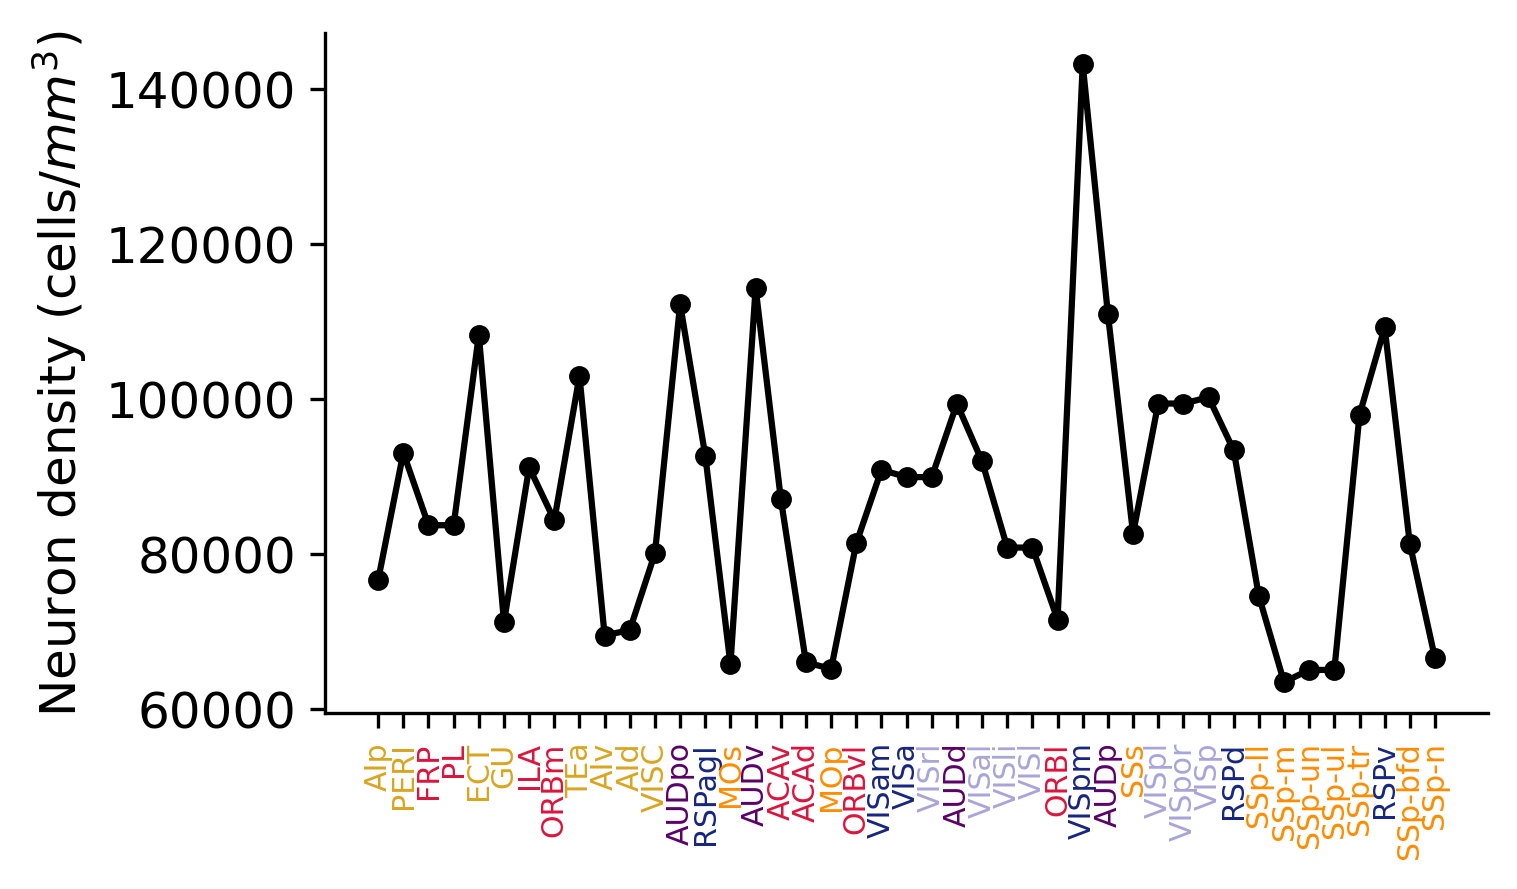

In [89]:
plotDensityBasedOnRawPVnotebook(density_rawPV_df, 8, r'Neuron density (cells/$mm^{3}$)', (5,3), 12, True, 'loadDataProcessing/densityBasedOnPVnotebook.svg')

In [90]:
# plot the neuron density with same order as pv cell density.
def plotRawDensitynotebook(grad_df, dotSize, yaxis, figureSize, fontSize, saveFig, fileName):
    
    dfRaw = grad_df.sort_values(grad_df.columns[0])

    fig = plt.figure(figsize = figureSize, dpi=300, facecolor='w', edgecolor='k')
    plt.rcParams.update({'font.size': fontSize})
    
    xx = np.arange(len(grad_df))
    plt.plot(xx, dfRaw.values, '.-', markersize=dotSize, color='k')
    plt.xticks(xx, dfRaw.index, rotation = 90, fontsize=fontSize*0.6)
    plt.ylabel(yaxis) #r'$e_i/e_1$'
    ax = plt.gca()
    for t in ax.xaxis.get_ticklabels():
        label = t._text
        for i in range(6):
            if label in div[div_name_list[i]]:
                t.set_color(div_color_list[i])
    # plt.grid(alpha = 0.5)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if saveFig:
        plt.savefig('figure/' + fileName, dpi=300, bbox_inches='tight',transparent=True)

In [91]:
# # plot pv norm by l23 density
# cellnormPVgrad_df = pd.DataFrame(np.array(PVgrad_df['raw PV density']) / np.array(l23density_df['l23 neuron density']), index = area_list, columns = ['cell norm PV density'])
# plotRawDensitynotebook(cellnormPVgrad_df, 8, r'cellnormPV cell density (cells/$mm^{3}$)', (5,3), 12, False, 'loadDataProcessing/cellnormPVnotebook.svg')

In [92]:
# inhcellnormPVgrad_df = pd.DataFrame(np.array(PVgrad_df['raw PV density']) / np.array(density_df['inhibitory neuron density']), index = area_list, columns = ['Inhibitory cell norm PV density'])
# plotRawDensitynotebook(inhcellnormPVgrad_df, 8, r'inhibitory cell norm PV density (cells/$mm^{3}$)', (5,3), 12, False, 'loadDataProcessing/inhcellnormPVnotebook.svg')

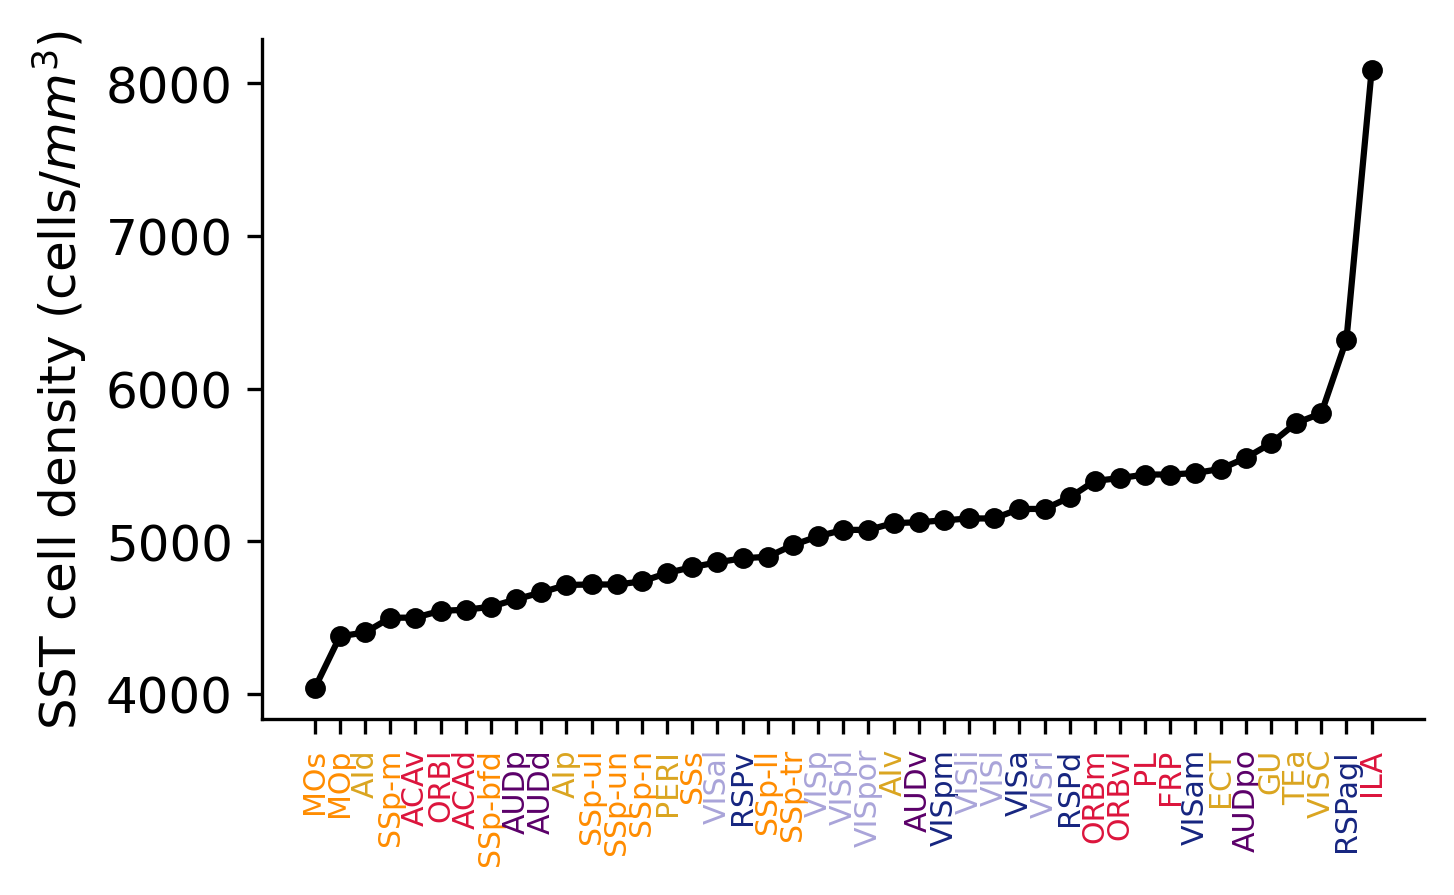

In [93]:
plotRawDensitynotebook(SSTgrad_df, 8, r'SST cell density (cells/$mm^{3}$)', (5,3), 12, True, 'loadDataProcessing/rawSSTnotebook.svg')

[[43.38177353]] [4188.84750712]


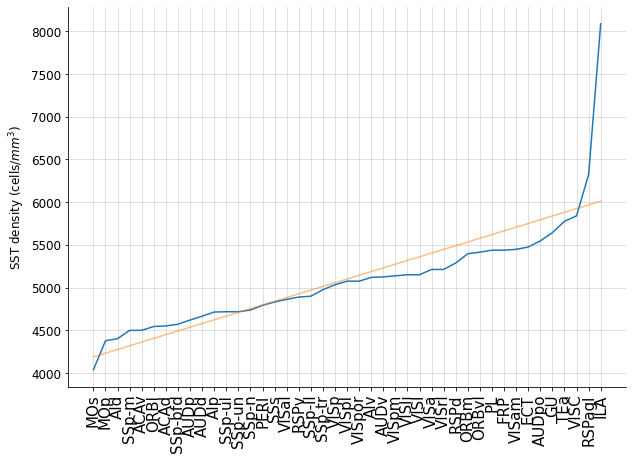

In [94]:

dfSST = SSTgrad_df.sort_values(SSTgrad_df.columns[0])

plt.figure(figsize = (10, 7))
xx = np.arange(len(dfSST))
plt.plot(xx, dfSST.values)
plt.xticks(xx, dfSST.index, rotation = 90, size = 15)
regSST = sk.linear_model.LinearRegression()
xx2 = xx[np.newaxis].T
regSST.fit(xx2, dfSST.values)
print(regSST.coef_, regSST.intercept_)
plt.plot(xx, xx * regSST.coef_[0][0] + regSST.intercept_[0], alpha = 0.5)

plt.ylabel('SST density (cells/' + r'$mm^{3}$' + ')')
plt.grid(alpha = 0.5)
axes = plt.gca()
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)

In [95]:
normPVcell_df

,norm PV gradient
ACAd,0.583489
ACAv,0.441409
AId,0.320715
AIp,0.000000
AIv,0.292444
AUDd,0.477634
AUDp,0.453504
AUDpo,0.238310
AUDv,0.326068
ECT,0.117383


In [96]:
# generate sorted dataframe of PV density.

sortednormPV_df = pd.DataFrame( [normPVcell_df['norm PV gradient'][i] for i in np.argsort(list(hierarchy_df['hierarchy index'])) ], index=sortedAreaList, columns=['norm PV gradient'])
sortednormPV_df.head()

,norm PV gradient
VISp,0.552770
AUDp,0.453504
SSp-ll,0.757232
AUDd,0.477634
SSp-n,1.000000


In [97]:
sortedrawPV_df = pd.DataFrame( [PVcell_df['raw PV density'][i] for i in np.argsort(list(hierarchy_df['hierarchy index'])) ], index=sortedAreaList, columns=['raw PV relative density'])
sortedrawPV_df.head()

,raw PV relative density
VISp,0.051292
AUDp,0.042700
SSp-ll,0.070069
AUDd,0.045401
SSp-n,0.090517


In [98]:
# save interneuron density
sortednormPV_df.to_csv('results/dfPV.csv')
sortedrawPV_df.to_csv('results/dfPVraw.csv')

# normPVgrad_df.to_csv('results/dfPV.csv')
# normSSTgrad_df.to_csv('results/dfSST.csv')
# PVgrad_df.to_csv('results/dfPVraw.csv')
# SSTgrad_df.to_csv('results/dfSSTraw.csv')

In [99]:
dfPV = pd.read_csv('results/dfPV.csv', header = 0, index_col=0)
print(len(dfPV))
dfPV.head()



43


,norm PV gradient
VISp,0.552770
AUDp,0.453504
SSp-ll,0.757232
AUDd,0.477634
SSp-n,1.000000


In [100]:
# generate sorted dataframe of hierarchy.

sortedHierarchy_df = pd.DataFrame( [hierarchy_df['hierarchy index'][i] for i in np.argsort(list(hierarchy_df['hierarchy index'])) ], index=sortedAreaList, columns=['hierarchy index'])
sortedHierarchy_df.head()

,hierarchy index
VISp,0.000000
AUDp,0.166607
SSp-ll,0.218547
AUDd,0.247638
SSp-n,0.268546


In [101]:
sortedHierarchy_df.to_csv('results/dfHier.csv')

In [102]:
# load thalamic hierarchy and save dataframe

THhierfilename = 'hier_th_extracted_CC_TC_CT_norm.csv'

with open('lib/' + THhierfilename, 'rb') as f:
    THhier_df = pd.read_csv(f, sep=',', names=['area', 'THhier'], header=0)
THhier_df = THhier_df.drop([34]) # remove RT area  reticular thalamic area  need to change
THhier_df = THhier_df.reset_index(drop=True)
print(np.array(THhier_df['THhier']).shape)
THhier_df = pd.DataFrame(np.array(THhier_df['THhier']), columns=['THhier'], index=np.array(THhier_df['area']))

(39,)


In [103]:
ta = np.array(THhier_df).squeeze()
print(ta.shape)


(39,)


Text(0, 0.5, 'Thalamic hierarchy index')

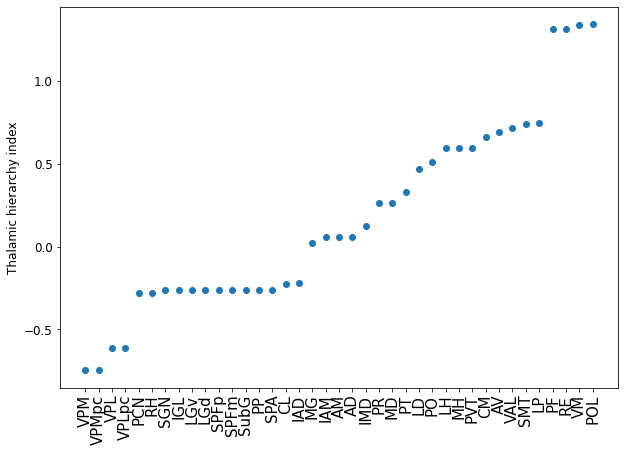

In [104]:
plt.figure(figsize = (10, 7))
plt.scatter(range(len(thal_acr)), ta[np.argsort(ta)])
plt.xticks(range(len(thal_acr)), np.array(thal_acr)[np.argsort(ta)], rotation = 90, size = 15)
plt.ylabel('Thalamic hierarchy index')

In [105]:
list(np.array(thal_acr)[np.argsort(ta)]).index(
    'AD')

20

In [106]:
THhier_df.to_csv('results/dfTHhier.csv')

(43, 39)

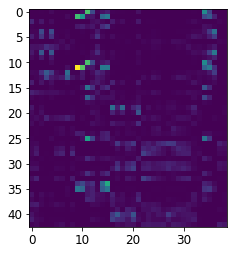

In [107]:
# design using thalamocortical conections to generate a thalamic hierarchy
plt.imshow(sortedconnthcx)
sortedconnthcx.shape

In [108]:
THhierRawfilename = 'hier_th_extracted_CC_TC_CT_norm.csv'

with open('lib/' + THhierfilename, 'rb') as f:
    THhierRaw_df = pd.read_csv(f, sep=',', names=['area', 'THhier'], header=0)
THhierRaw_df

,area,THhier
0,VAL,0.717412
1,VM,1.338554
2,VPL,-0.611942
3,VPLpc,-0.611942
4,VPM,-0.746676
5,VPMpc,-0.746676
6,SPFm,-0.262572
7,SPFp,-0.262572
8,SPA,-0.262572
9,PP,-0.262572
